# Installing Packages and Importing Data

In [1]:
%load_ext autoreload

%autoreload 2


In [5]:
import dill
#dill.dump_session("RF_nldasDebugged.db")
dill.load_session("RF_nldas.db")

/Users/Thugg/opt/miniconda3/envs/AIS/lib/python3.7/site-packages/dill/_dill.py:473: UserWarning: This figure was saved with matplotlib version 3.0.3 and is unlikely to function correctly.
  obj = StockUnpickler.load(self)


In [1]:
import sys
import os
print(sys.executable) 
print(sys.version) 
print(sys.version_info)
print(os.getcwd())
print(sys.path)
sys.path.append("/Users/Thugg/opt/miniconda3/envs/AIS/lib/python3.7/site-packages")

/Users/Thugg/opt/miniconda3/envs/AIS/bin/python
3.7.7 (default, May  6 2020, 04:59:01) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
/Users/Thugg/Documents/UM/Summer_2020/Jupyter
['/Users/Thugg/Documents/UM/Summer_2020/Jupyter', '/Users/Thugg/opt/miniconda3/envs/AIS/lib/python37.zip', '/Users/Thugg/opt/miniconda3/envs/AIS/lib/python3.7', '/Users/Thugg/opt/miniconda3/envs/AIS/lib/python3.7/lib-dynload', '', '/Users/Thugg/opt/miniconda3/envs/AIS/lib/python3.7/site-packages', '/Users/Thugg/opt/miniconda3/envs/AIS/lib/python3.7/site-packages/IPython/extensions', '/Users/Thugg/.ipython']


In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import pickle as pkl
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from drop_col import drop_col
from sklearn.base import clone
from zlib import crc32
from drop_collinear import drop_collinear
from run_rf import run_rf
from stratx import *
from stratx.featimp import *
from functools import reduce
from rfpimp import feature_dependence_matrix, plot_dependence_heatmap


In [20]:
#Read in CSV from Clean_CSV.pynb
csv_WCT = pd.read_csv("WCT_Clean.csv")
csv_RBT = pd.read_csv("RBT_Clean.csv")

In [8]:
pd.set_option("display.max_columns",100)
csv_RBT.columns

Index(['Cloud', 'Heat-Insolation Load', 'Lithology', 'Max_LST_Annual',
       'Mean_EVI', 'Mean_GPP', 'Mean_NDVI', 'Percent_NonTree_Vegetation',
       'Percent_NonVegetated', 'Percent_Tree_Cover', 'Physiography',
       'Topographic Diversity', 'weightedPRBT', 'areasqkm', 'change_abs',
       'change_norm', 'elevation', 'fall_diffHumidity',
       'fall_diffPotentialEvap', 'fall_diffPrecip', 'fall_diffTemp',
       'fall_totalHumidity', 'fall_totalPotentialEvap', 'fall_totalPrecip',
       'fall_totalTemp', 'gHM', 'huc12', 'occurrence', 'recurrence',
       'seasonality', 'spring_diffHumidity', 'spring_diffPotentialEvap',
       'spring_diffPrecip', 'spring_diffTemp', 'spring_totalHumidity',
       'spring_totalPotentialEvap', 'spring_totalPrecip', 'spring_totalTemp',
       'summer_diffHumidity', 'summer_diffPotentialEvap', 'summer_diffPrecip',
       'summer_diffTemp', 'summer_totalHumidity', 'summer_totalPotentialEvap',
       'summer_totalPrecip', 'summer_totalTemp', 'total_precip

# EDA

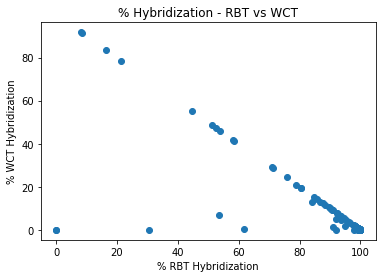

In [9]:
#Basic Sanity Check!
plt.xlabel("% RBT Hybridization")
plt.ylabel("% WCT Hybridization")
plt.title("% Hybridization - RBT vs WCT")
plt.plot(csv_WCT['weightedPWCT'],csv_RBT['weightedPRBT'], 'o')

(array([107.,   9.,   4.,   2.,   2.,   3.,   1.,   0.,   1.,   3.]),
 array([ 0.        ,  9.17445022, 18.34890045, 27.52335067, 36.6978009 ,
        45.87225112, 55.04670135, 64.22115157, 73.3956018 , 82.57005202,
        91.74450225]),
 <a list of 10 Patch objects>)

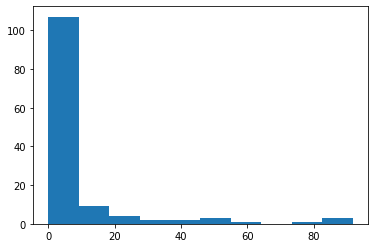

In [10]:
plt.hist(csv_RBT['weightedPRBT'])

# Last minute cleaning and dropping collinear columns

In [21]:
X_wct = csv_WCT.drop(['weightedPWCT','Percent_NonTree_Vegetation',
                      'Percent_NonVegetated','fall_totalPrecip','Cloud','huc12'], axis=1)

y_wct = csv_WCT['weightedPWCT']
X_rbt = csv_RBT.drop(['weightedPRBT','Percent_NonTree_Vegetation',
                      'Percent_NonVegetated','fall_totalPrecip','Cloud','huc12'],axis=1)
y_rbt = csv_RBT['weightedPRBT']




## Drop Collinear Columns

In [22]:
#Drop Collinear Columns
X_wct_collinear = drop_collinear(X_wct,0.7)
X_rbt_collinear = drop_collinear(X_rbt,0.7)

In [16]:
X_rbt_collinear.columns

Index(['Heat-Insolation Load', 'Lithology', 'Max_LST_Annual', 'Mean_EVI',
       'Mean_GPP', 'Percent_Tree_Cover', 'Topographic Diversity', 'AreaSqKm',
       'Abs_Water_Change', 'Norm_Water_Change', 'Elevation',
       'Human Modification', 'HUCID', 'Occurrence', 'Recurrence',
       'fall_totalPotentialEvap', 'gHM', 'occurrence', 'spring_diffHumidity',
       'spring_diffPotentialEvap', 'spring_diffPrecip', 'spring_diffTemp',
       'spring_totalPotentialEvap', 'spring_totalPrecip',
       'summer_diffHumidity', 'summer_diffPotentialEvap', 'summer_diffPrecip',
       'summer_diffTemp', 'summer_totalPotentialEvap', 'total_precipitation',
       'winter_diffHumidity', 'winter_diffPotentialEvap', 'winter_diffPrecip',
       'winter_diffTemp', 'winter_totalPotentialEvap', 'winter_totalPrecip'],
      dtype='object')

# Iteratively drop Partial Dependencies

## Westslope Cutthroat

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)

partial_dependencies = feature_dependence_matrix(X_train)

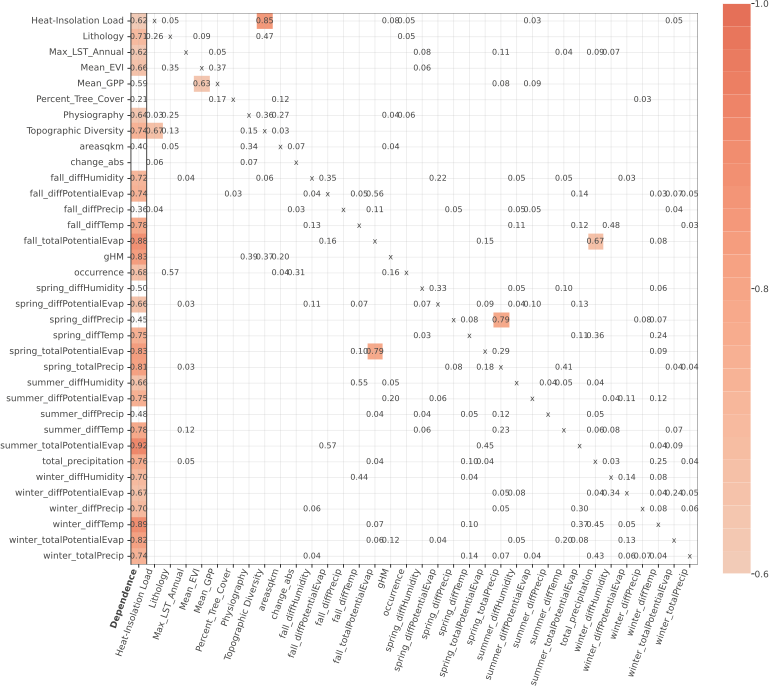

In [25]:
viz = plot_dependence_heatmap(partial_dependencies, figsize=(11,10))
#viz.save("plots/Partial_Dependency_Heatmap.svg")
viz

In [122]:


multicollinear = ['occurrence','Heat-Insolation Load','winter_diffHumidity',
                 'winter_totalPrecip','spring_diffPrecip']
#Drop Multicollinear Columns
X_wct_collinear = X_wct_collinear.drop(columns=multicollinear,axis=1)

In [27]:
keep_rbt

['Heat-Insolation Load',
 'Lithology',
 'Max_LST_Annual',
 'Mean_GPP',
 'Percent_Tree_Cover',
 'areasqkm',
 'change_abs',
 'fall_diffHumidity',
 'fall_diffPotentialEvap',
 'fall_diffPrecip',
 'occurrence',
 'spring_diffHumidity',
 'spring_diffPotentialEvap',
 'spring_totalPrecip',
 'summer_diffHumidity',
 'summer_diffPotentialEvap',
 'summer_diffPrecip',
 'summer_diffTemp',
 'total_precipitation',
 'winter_diffHumidity',
 'winter_diffPrecip',
 'winter_totalPotentialEvap',
 'winter_totalPrecip']

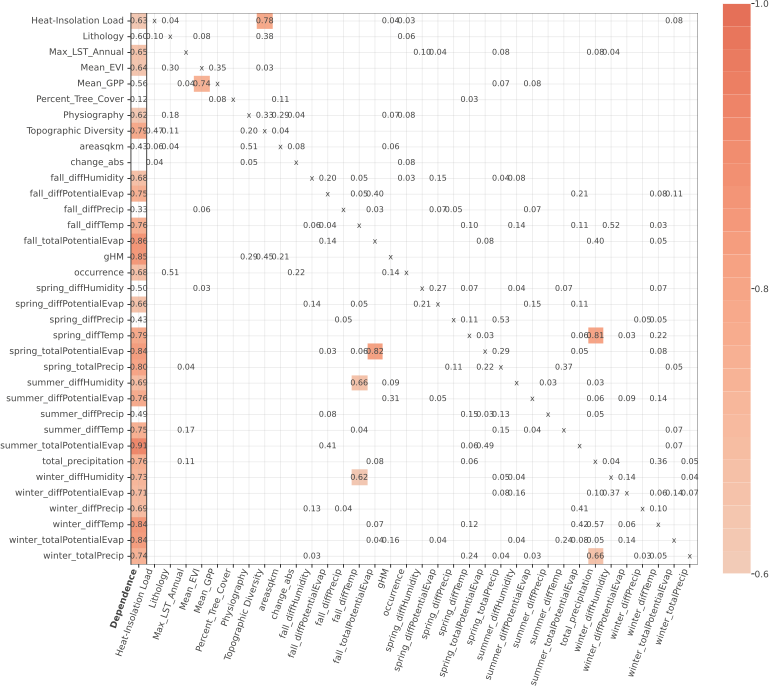

In [26]:
#Check partial dependence matrix again
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)

partial_dependencies_wct = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_wct, figsize=(11,10))

In [28]:
#Iteratively Drop Partially dependent columns
multicollinear = ['Mean_EVI','Topographic Diversity','fall_diffTemp',
                  'summer_diffHumidity','spring_totalPotentialEvap','spring_diffTemp']
X_wct_collinear = X_wct_collinear.drop(columns = multicollinear,axis=1)



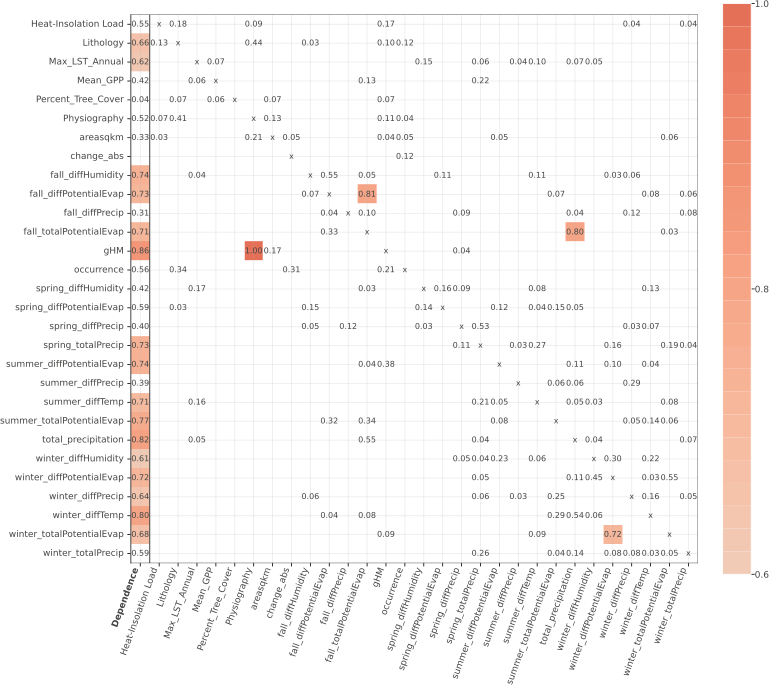

In [29]:
#Check partial dependence matrix again for RBT
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 3)

partial_dependencies_wct = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_wct, figsize=(11,10))

In [30]:
#Iteratively Drop Partially dependent columns
multicollinear = ['gHM','fall_diffPotentialEvap','fall_totalPotentialEvap',
                  'winter_totalPotentialEvap']
X_wct_collinear = X_wct_collinear.drop(columns = multicollinear,axis=1)




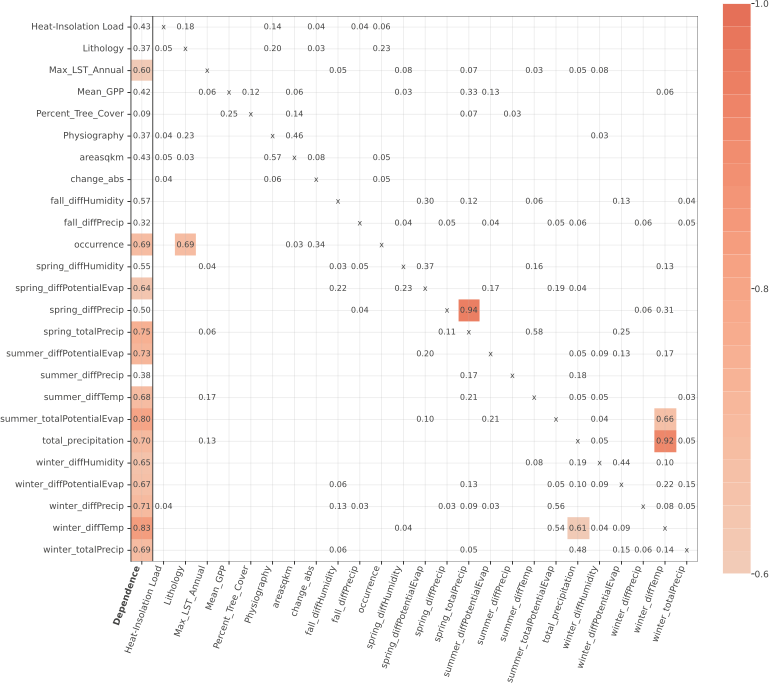

In [31]:
#Check partial dependence matrix again for WCT
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)

partial_dependencies_wct = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_wct, figsize=(11,10))

In [32]:
#Iteratively Drop Partially dependent columns
multicollinear = ['occurrence','spring_diffPrecip','winter_diffTemp','summer_totalPotentialEvap']
X_wct_collinear = X_wct_collinear.drop(columns = multicollinear,axis=1)




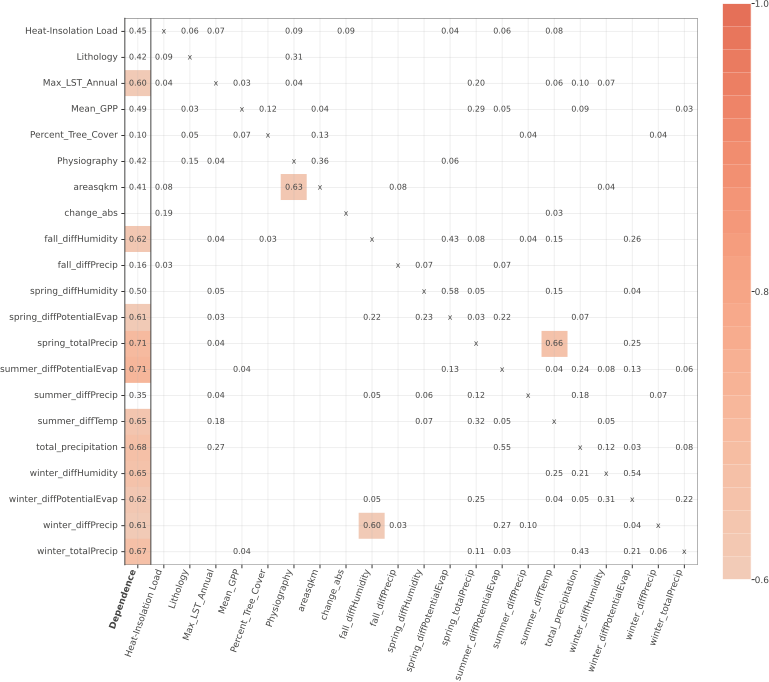

In [33]:
#Check partial dependence matrix again for WCT
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)

partial_dependencies_wct = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_wct, figsize=(11,10))

In [34]:
#Iteratively Drop Partially dependent columns
multicollinear = ['summer_diffTemp','Physiography']
X_wct_collinear = X_wct_collinear.drop(columns = multicollinear,axis=1)




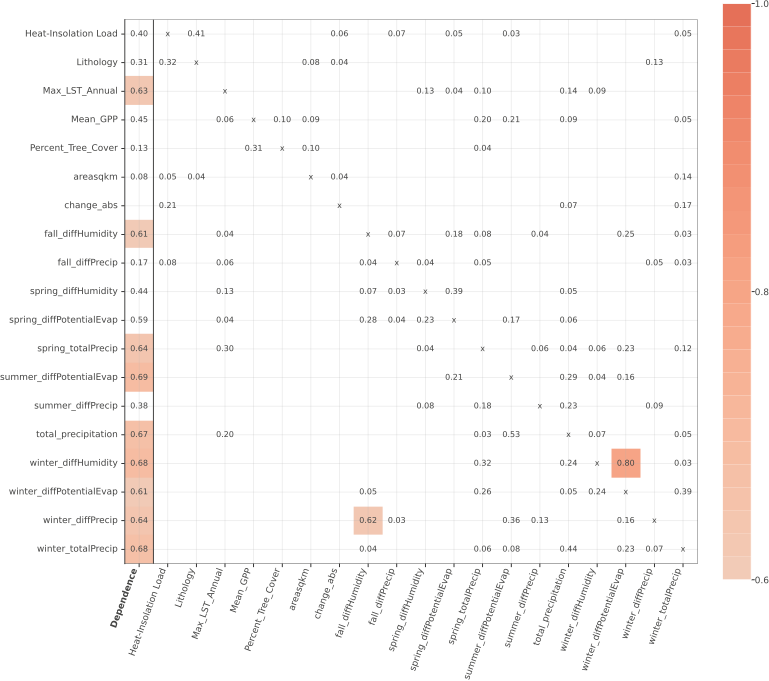

In [35]:
#Check partial dependence matrix again for WCT
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)

partial_dependencies_wct = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_wct, figsize=(11,10))

In [36]:
#Iteratively Drop Partially dependent columns
multicollinear = ['fall_diffHumidity','winter_diffPotentialEvap']
X_wct_collinear = X_wct_collinear.drop(columns = multicollinear,axis=1)




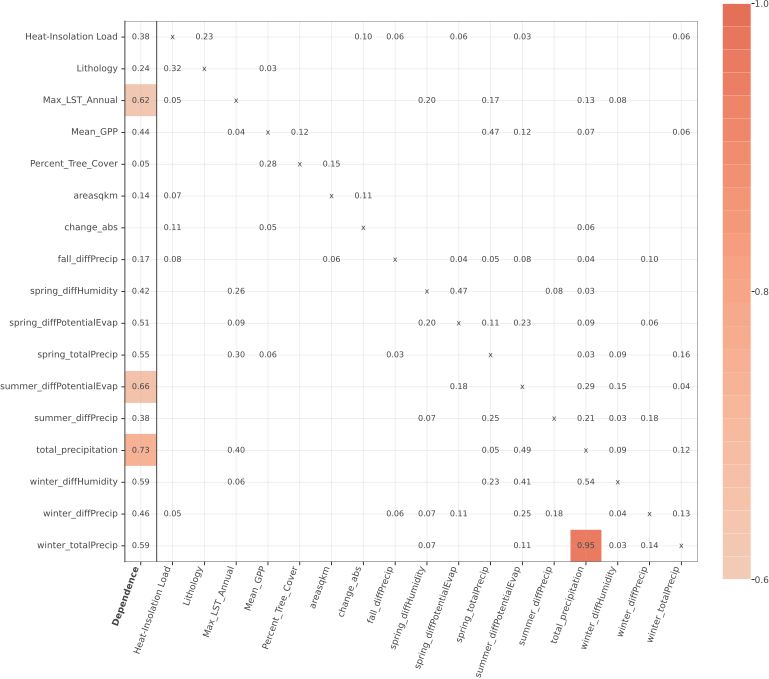

In [37]:
#Check partial dependence matrix again for WCT
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)

partial_dependencies_wct = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_wct, figsize=(11,10))

In [41]:
X_wct_collinear.columns

Index(['Heat-Insolation Load', 'Lithology', 'Max_LST_Annual', 'Mean_GPP',
       'Percent_Tree_Cover', 'areasqkm', 'change_abs', 'fall_diffPrecip',
       'spring_diffHumidity', 'spring_diffPotentialEvap', 'spring_totalPrecip',
       'summer_diffPotentialEvap', 'summer_diffPrecip', 'total_precipitation',
       'winter_diffHumidity', 'winter_diffPrecip', 'winter_totalPrecip'],
      dtype='object')

In [42]:
keep_wct=['Heat-Insolation Load', 'Lithology', 'Max_LST_Annual', 'Mean_GPP',
       'Percent_Tree_Cover', 'areasqkm', 'change_abs', 'fall_diffPrecip',
       'spring_diffHumidity', 'spring_diffPotentialEvap', 'spring_totalPrecip',
       'summer_diffPotentialEvap', 'summer_diffPrecip', 'total_precipitation',
       'winter_diffHumidity', 'winter_diffPrecip', 'winter_totalPrecip']

In [38]:
print(X_wct_collinear.shape)
print(X_rbt_collinear.shape)

(132, 17)
(132, 23)


## Rainbow Trout

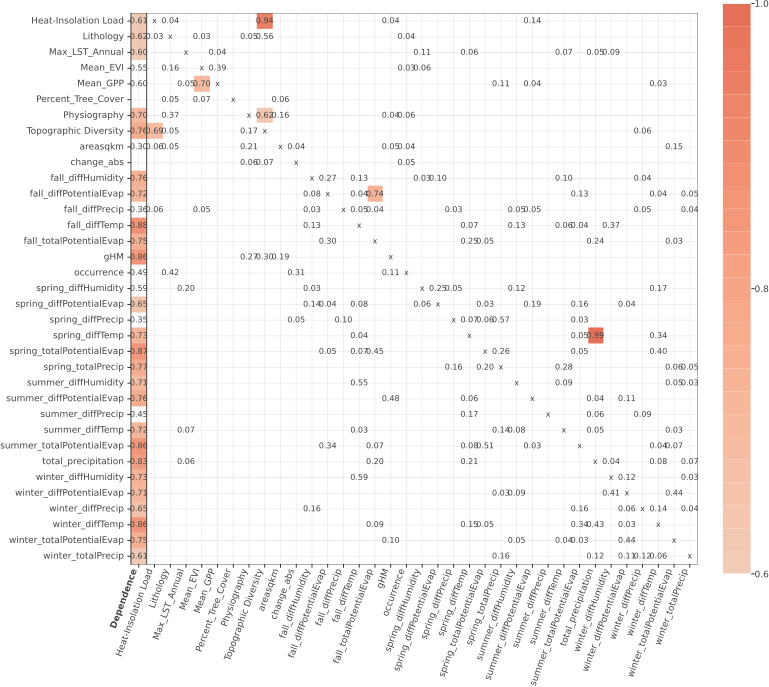

In [16]:
#Check partial dependence matrix again
X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)

partial_dependencies_rbt = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_rbt, figsize=(11,10))

In [17]:
multicollinear = ['Mean_EVI','Topographic Diversity','fall_totalPotentialEvap',"spring_diffTemp"]

X_rbt_collinear = X_rbt_collinear.drop(columns=multicollinear,axis=1)

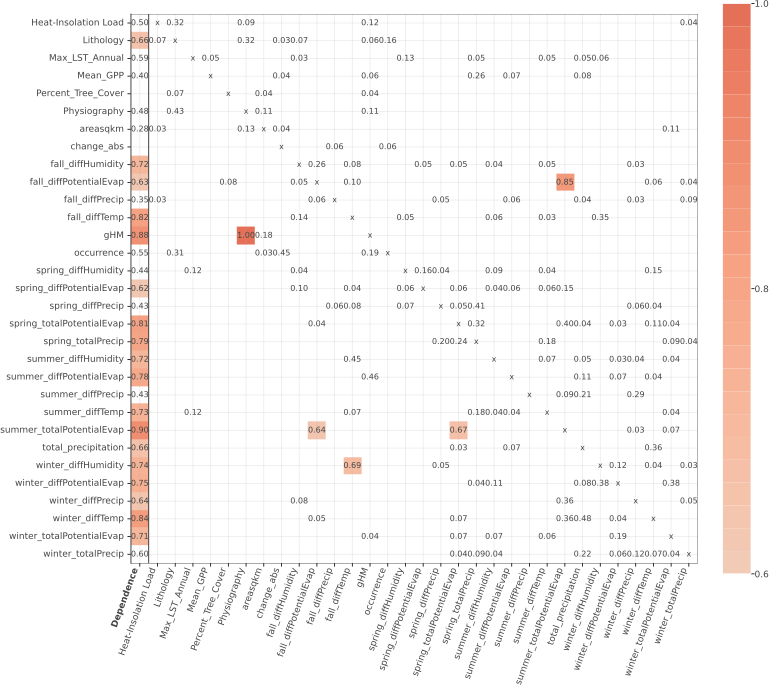

In [18]:
#Check partial dependence matrix again
X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)

partial_dependencies_rbt = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_rbt, figsize=(11,10))

In [19]:
multicollinear = ['Physiography','fall_diffTemp','spring_totalPotentialEvap','summer_totalPotentialEvap']
X_rbt_collinear = X_rbt_collinear.drop(columns=multicollinear,axis=1)

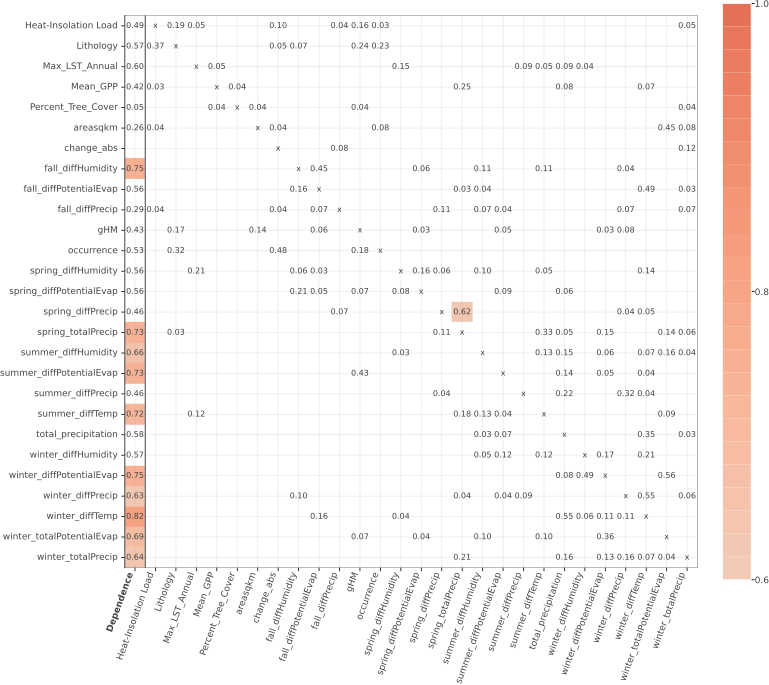

In [20]:
#Check partial dependence matrix again
X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)

partial_dependencies_rbt = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_rbt, figsize=(11,10))

In [21]:
multicollinear = ['spring_diffPrecip']
X_rbt_collinear = X_rbt_collinear.drop(columns=multicollinear,axis=1)

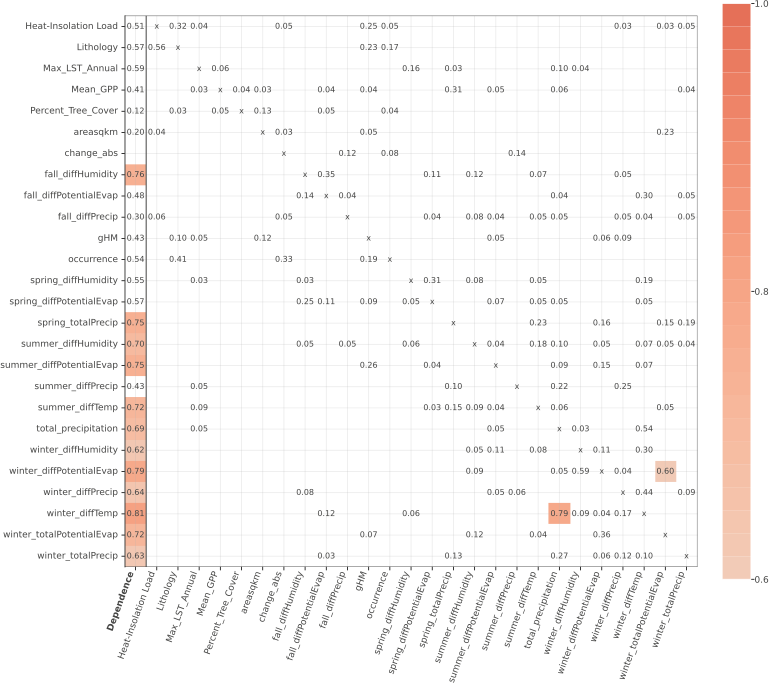

In [22]:
#Check partial dependence matrix again
X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)

partial_dependencies_rbt = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_rbt, figsize=(11,10))

In [23]:
multicollinear = ['winter_diffTemp','winter_diffPotentialEvap']
X_rbt_collinear = X_rbt_collinear.drop(columns=multicollinear,axis=1)

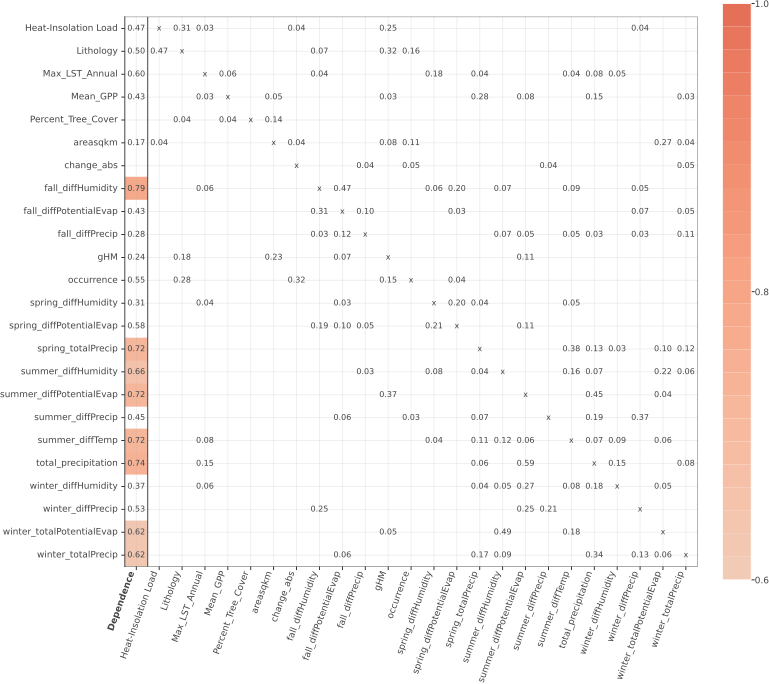

In [24]:
#Check partial dependence matrix again
X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)

partial_dependencies_rbt = feature_dependence_matrix(X_train)
plot_dependence_heatmap(partial_dependencies_rbt, figsize=(11,10))

In [29]:
X_rbt_collinear.shape

(132, 24)

In [193]:
#rbt multicollinear features to drop:
d=['winter_diffHumidity', 'gHM', 'HUCID', 
'Mean_EVI', 'Topographic Diversity', 
'Heat-Insolation Load', 'spring_diffTemp', 
'Lithology', 'summer_diffHumidity', 'fall_totalPotentialEvap', 
'spring_diffPrecip', 'winter_diffPotentialEvap', 'winter_diffTemp']


In [31]:
X_rbt_collinear.columns

Index(['Heat-Insolation Load', 'Lithology', 'Max_LST_Annual', 'Mean_GPP',
       'Percent_Tree_Cover', 'areasqkm', 'change_abs', 'fall_diffHumidity',
       'fall_diffPotentialEvap', 'fall_diffPrecip', 'gHM', 'occurrence',
       'spring_diffHumidity', 'spring_diffPotentialEvap', 'spring_totalPrecip',
       'summer_diffHumidity', 'summer_diffPotentialEvap', 'summer_diffPrecip',
       'summer_diffTemp', 'total_precipitation', 'winter_diffHumidity',
       'winter_diffPrecip', 'winter_totalPotentialEvap', 'winter_totalPrecip'],
      dtype='object')

In [ ]:
X_rbt = csv_RBT.drop(d)

In [13]:
#To keep:

keep_rbt=['Heat-Insolation Load', 'Lithology', 'Max_LST_Annual', 'Mean_GPP',
       'Percent_Tree_Cover', 'areasqkm', 'change_abs', 'fall_diffHumidity',
       'fall_diffPotentialEvap', 'fall_diffPrecip', 'occurrence',
       'spring_diffHumidity', 'spring_diffPotentialEvap', 'spring_totalPrecip',
       'summer_diffHumidity', 'summer_diffPotentialEvap', 'summer_diffPrecip',
       'summer_diffTemp', 'total_precipitation', 'winter_diffHumidity',
       'winter_diffPrecip', 'winter_totalPotentialEvap', 'winter_totalPrecip']

# Fit Random Forest for both species

## Westslope Cutthroat Trout

In [ ]:
X_wct_collinear = X_wct_collinear[keep_wct]

In [45]:
#//========================================================
#WCT========================================================
#//========================================================

X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)
wct_rf = RandomForestRegressor(n_estimators = 500, oob_score = True, random_state=3)
wct_rf.fit(X_train,y_train)



RandomForestRegressor(n_estimators=500, oob_score=True, random_state=3)

In [46]:
#WCT EVALUATION
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)
print(wct_rf.score(X_test,y_test))

predictions = wct_rf.predict(X_test)
errors = abs(predictions - y_test)

print("OOB score:", wct_rf.oob_score_)
print("Mean Absolute Error: ", round(np.mean(errors),2),'%')

0.4033914244068051
OOB score: 0.07354231678900758
Mean Absolute Error:  10.1 %


### Residual Analysis

(0.0, 100.0)

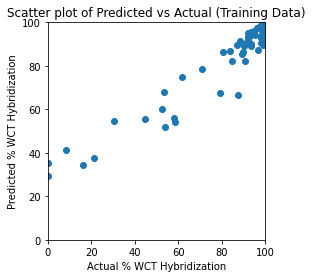

In [47]:
ax = plt.subplot()
predict_train = wct_rf.predict(X_train)
plt.plot(y_train,predict_train, 'o')
plt.ylabel("Predicted % WCT Hybridization"); 
plt.xlabel("Actual % WCT Hybridization"); 
plt.title("Scatter plot of Predicted vs Actual (Training Data)")
ax.set_aspect('equal')
ax.set_xlim(0,100)
ax.set_ylim(0,100)

/Users/Thugg/opt/miniconda3/envs/AIS/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  


(0.0, 100.0)

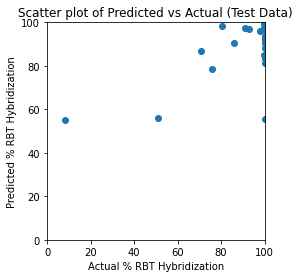

In [48]:
ax = plt.subplot()
plt.plot(y_test,predictions, 'o')
plt.ylabel("Predicted % RBT Hybridization"); 
plt.xlabel("Actual % RBT Hybridization"); 
plt.title("Scatter plot of Predicted vs Actual (Test Data)")
plt.axis(xlim = (0,100), ylim = (0,100))
ax.set_aspect('equal')
ax.set_xlim(0,100)
ax.set_ylim(0,100)

In [ ]:
pkl.

## Rainbow Trout 

In [23]:
X_rbt_collinear = X_rbt_collinear[keep_rbt]

In [52]:
#//========================================================
#RBT========================================================
#//========================================================

X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)
rbt_rf = RandomForestRegressor(n_estimators = 600, oob_score = True,random_state = 3)
rbt_rf.fit(X_train,y_train)



RandomForestRegressor(n_estimators=600, oob_score=True, random_state=3)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)
print(rbt_rf.score(X_test,y_test))

predictions = rbt_rf.predict(X_test)
errors = abs(predictions - (y_test))

print("OOB score" , rbt_rf.oob_score_)
print("Mean Absolute Error: ", round(np.mean(errors),2))

0.6887640346778086
OOB score 0.22929631643860648
Mean Absolute Error:  7.02


In [54]:
#Save model to file
model_out = "rbt_rf_featSelection.pkl"
with open(model_out, 'wb') as file:
    pickle.dump(rbt_rf,file)

In [95]:
min(y_test)

0.14790893340230155

In [96]:
y_rbt.iloc[[114]]

114    0.362308
Name: weightedPRBT, dtype: float64

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  2., 10.,  7.,  6.]),
 array([-45.56926974, -39.64524218, -33.72121461, -27.79718705,
        -21.87315949, -15.94913193, -10.02510436,  -4.1010768 ,
          1.82295076,   7.74697832,  13.67100589]),
 <a list of 10 Patch objects>)

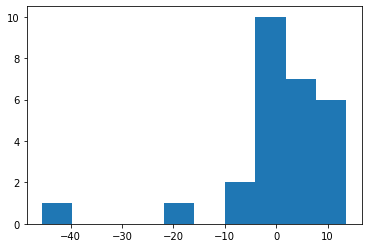

In [37]:
plt.hist(predictions - (y_test))

### Residual Analysis

(0.0, 100.0)

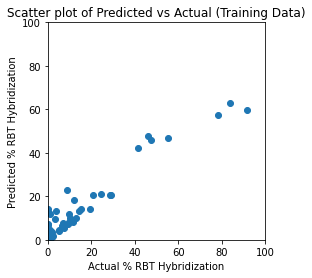

In [38]:
ax = plt.subplot()
predict_train = rbt_rf.predict(X_train)
plt.plot(y_train,predict_train, 'o')
plt.ylabel("Predicted % RBT Hybridization"); 
plt.xlabel("Actual % RBT Hybridization"); 
plt.title("Scatter plot of Predicted vs Actual (Training Data)")
ax.set_aspect('equal')
ax.set_xlim(0,100)
ax.set_ylim(0,100)

(0.0, 100.0)

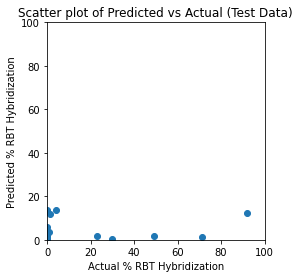

In [39]:
ax = plt.subplot()
plt.plot(100*y_test,predictions, 'o')
plt.ylabel("Predicted % RBT Hybridization"); 
plt.xlabel("Actual % RBT Hybridization"); 
plt.title("Scatter plot of Predicted vs Actual (Test Data)")
ax.set_aspect('equal')
ax.set_xlim(0,100)
ax.set_ylim(0,100)

Text(0.5, 1.0, 'Residual Plot for RBT')

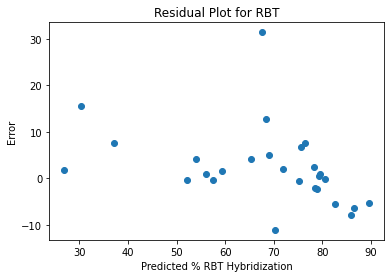

In [104]:
plt.plot(predictions,(predictions - 100*y_test), 'o')

plt.ylabel("Error"); 
plt.xlabel("Predicted % RBT Hybridization"); 
plt.title("Residual Plot for RBT")

# Feature Importances

## Westslope Cutthroat

In [105]:
wct_imp = importances(X = X_wct_collinear,
                      y = y_wct, 
                      n_trees = 100, 
                      n_trials = 50,
                      min_samples_leaf = 15,
                      n_jobs = -1)

PARAMETERS:
	n=|X|                132
	n_trials             50
	min_samples_leaf     15
	cat_min_samples_leaf 5
	min_slopes_per_x     5
	bootstrap            True
	n_trees              100
Impact importance time 7s
Impact importance time 2s
Impact importance time 2s
Impact importance time 2s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impact importance time 1s
Impac

In [106]:
wct_imp.sort_values(["Importance"],ascending = False)

Importance  Importance sigma    Impact  Impact sigma
Feature                                                                       
AreaSqKm                    0.214031          0.083445  0.206494      0.081197
summer_diffPrecip           0.092824          0.067806  0.094458      0.068813
spring_totalPrecip          0.089314          0.057895  0.090491      0.058120
Elevation                   0.069790          0.037390  0.070367      0.038101
Occurrence                  0.069597          0.028093  0.070883      0.028466
total_precipitation         0.064184          0.042547  0.065257      0.043192
Percent_Tree_Cover          0.062661          0.042406  0.063619      0.042403
Norm_Water_Change           0.053989          0.038462  0.053907      0.038613
Human Modification          0.052685          0.031810  0.053663      0.032515
winter_diffPotentialEvap    0.043296          0.041072  0.044123      0.041755
spring_diffHumidity         0.038672          0.023826  0.039189      0.024041
Mean_GPP                    0.033260          0.012564  0.033523      0.012840
Max_LST_Annual              0.031581          0.008775  0.032053      0.009306
summer_diffPotentialEvap    0.029771          0.009308  0.030291      0.009219
spring_diffPotentialEvap    0.029693          0.011052  0.030300      0.011226
Abs_Water_Change            0.024651          0.007811  0.021382      0.006618

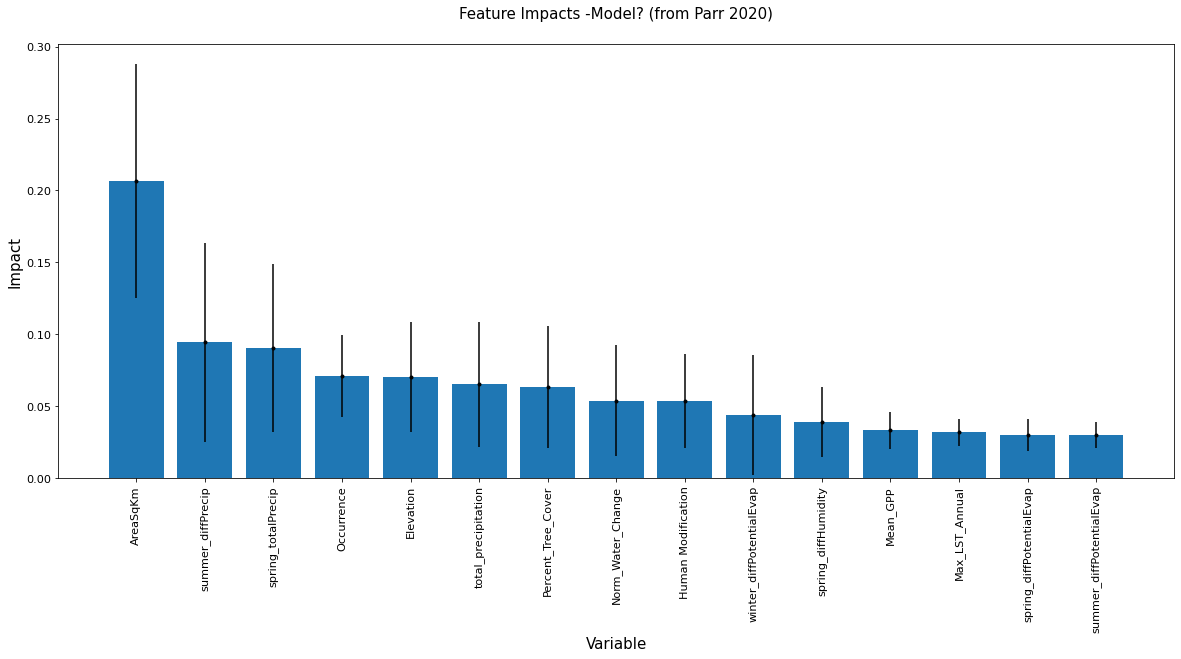

In [169]:
var_for_df = wct_imp.index
wct_imp['feature'] = var_for_df


wct_imp_first = wct_imp.sort_values("Impact",ascending = False)[:15]#.reset_index(drop=False)
xs = wct_imp_first.index
impact = wct_imp_first['Impact']
variable = wct_imp_first.index
wct_imp_first['feature'] = variable

plt.bar(xs, impact, orientation = 'vertical')
plt.errorbar(xs, impact, c = 'black',yerr = wct_imp_first['Impact sigma'], fmt = '.')

plt.xticks(xs, variable, rotation = 'vertical')

plt.ylabel("Impact"); plt.xlabel("Variable"); plt.title("Feature Impacts -Model? (from Parr 2020)")
plt.show()

In [170]:
#Do not run-- drop column analysis
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)
drop_col_imp = drop_col(wct_rf, X_train, y_train, random_state = 10)

In [171]:
drop_col_imp.sort_values(["feature_importance"],ascending = False)

feature  feature_importance
0                   AreaSqKm            0.016075
1                  Elevation            0.007762
2                 Occurrence            0.007485
3          Norm_Water_Change            0.000329
4   summer_diffPotentialEvap            0.000125
5          summer_diffPrecip           -0.000308
6        spring_diffHumidity           -0.000379
7                   Mean_GPP           -0.000492
8        total_precipitation           -0.000807
9   winter_diffPotentialEvap           -0.000976
10        Human Modification           -0.000983
11        spring_totalPrecip           -0.001318
12  spring_diffPotentialEvap           -0.001328
13          Abs_Water_Change           -0.002055
14        Percent_Tree_Cover           -0.002065
15            Max_LST_Annual           -0.002267

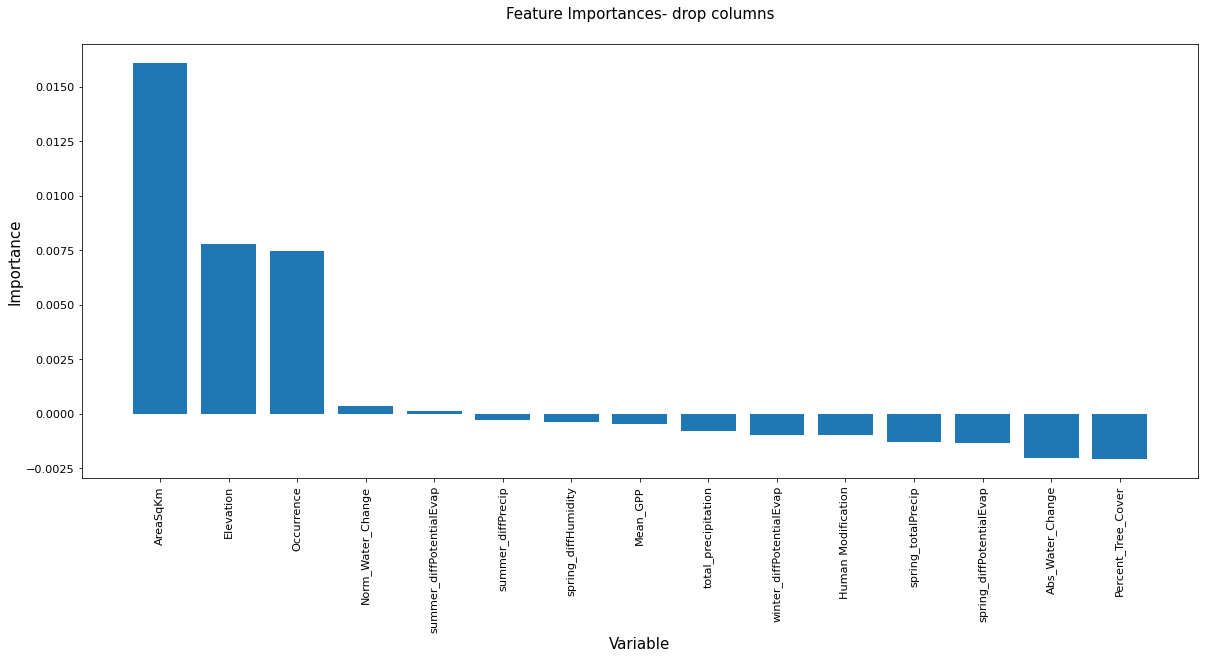

In [172]:
drop_col_imp_first = drop_col_imp.sort_values("feature_importance",ascending = False)[:15]#.reset_index(drop=False)
xs = drop_col_imp_first.index
impact = drop_col_imp_first['feature_importance']
variable = drop_col_imp_first.index
drop_col_imp_first['feature']

plt.bar(xs, impact, orientation = 'vertical')

plt.xticks(xs, drop_col_imp_first['feature'], rotation = 'vertical')

plt.ylabel("Importance"); plt.xlabel("Variable"); plt.title("Feature Importances- drop columns")
plt.show()

In [173]:
#Do not run- permutation importance
X_train, X_test, y_train, y_test = train_test_split(X_wct_collinear,
                                                y_wct,
                                                test_size = 0.2, 
                                                random_state = 1)
perm = permutation_importance(wct_rf, X_train, y_train, n_repeats = 30, random_state = 10)

### Constructing Dataframe and plots for Comparison

In [174]:
wct_imp.transpose()

Feature            AreaSqKm  Occurrence   Mean_GPP  Max_LST_Annual  \
Importance         0.214031   0.0695973  0.0332596       0.0315812   
Importance sigma  0.0834453   0.0280929  0.0125635      0.00877545   
Impact             0.206494   0.0708833  0.0335231       0.0320534   
Impact sigma      0.0811974   0.0284663  0.0128402      0.00930581   
feature            AreaSqKm  Occurrence   Mean_GPP  Max_LST_Annual   

Feature           summer_diffPotentialEvap  spring_diffPotentialEvap  \
Importance                       0.0297713                 0.0296933   
Importance sigma                 0.0093075                 0.0110518   
Impact                           0.0302911                 0.0302997   
Impact sigma                    0.00921871                 0.0112262   
feature           summer_diffPotentialEvap  spring_diffPotentialEvap   

Feature           Abs_Water_Change  summer_diffPrecip  spring_totalPrecip  \
Importance               0.0246508          0.0928237           0.0893142   
Importance sigma        0.00781078           0.067806            0.057895   
Impact                   0.0213818          0.0944576           0.0904907   
Impact sigma            0.00661771          0.0688126           0.0581202   
feature           Abs_Water_Change  summer_diffPrecip  spring_totalPrecip   

Feature           Elevation  total_precipitation  Percent_Tree_Cover  \
Importance        0.0697901            0.0641841           0.0626615   
Importance sigma  0.0373898            0.0425471           0.0424056   
Impact            0.0703674            0.0652571           0.0636191   
Impact sigma      0.0381008            0.0431916           0.0424032   
feature           Elevation  total_precipitation  Percent_Tree_Cover   

Feature           Norm_Water_Change  Human Modification  \
Importance                0.0539889            0.052685   
Importance sigma          0.0384619           0.0318104   
Impact                    0.0539066           0.0536628   
Impact sigma              0.0386126           0.0325153   
feature           Norm_Water_Change  Human Modification   

Feature           winter_diffPotentialEvap  spring_diffHumidity  
Importance                       0.0432957            0.0386723  
Importance sigma                  0.041072            0.0238265  
Impact                           0.0441229            0.0391893  
Impact sigma                     0.0417554            0.0240414  
feature           winter_diffPotentialEvap  spring_diffHumidity

In [175]:
par_imp = wct_imp[['feature','Importance','Importance sigma']] 
par_imp = par_imp \
            .rename(columns = dict(zip(par_imp.columns,['feature','feature_importance','importance_sd']))) \
            .sort_values("feature_importance",ascending = False)
perm_imp_df = pd.DataFrame({"feature": X_train.columns,
                           "feature_importance": perm.importances_mean,
                           "feat_imp_sd": perm.importances_std}) \
                        .sort_values('feature_importance',ascending = False).reset_index(drop=True)
drop_imp = drop_col_imp.sort_values('feature_importance',ascending = False).reset_index(drop=True)


In [176]:
#Append rank to each data frame
def give_rank(df):
    df['rank'] = np.arange(1,len(df)+1)
    return df


par_imp = give_rank(par_imp)
perm_imp_df = give_rank(perm_imp_df)
drop_imp = give_rank(drop_imp)
dfs = [par_imp,perm_imp_df,drop_imp]

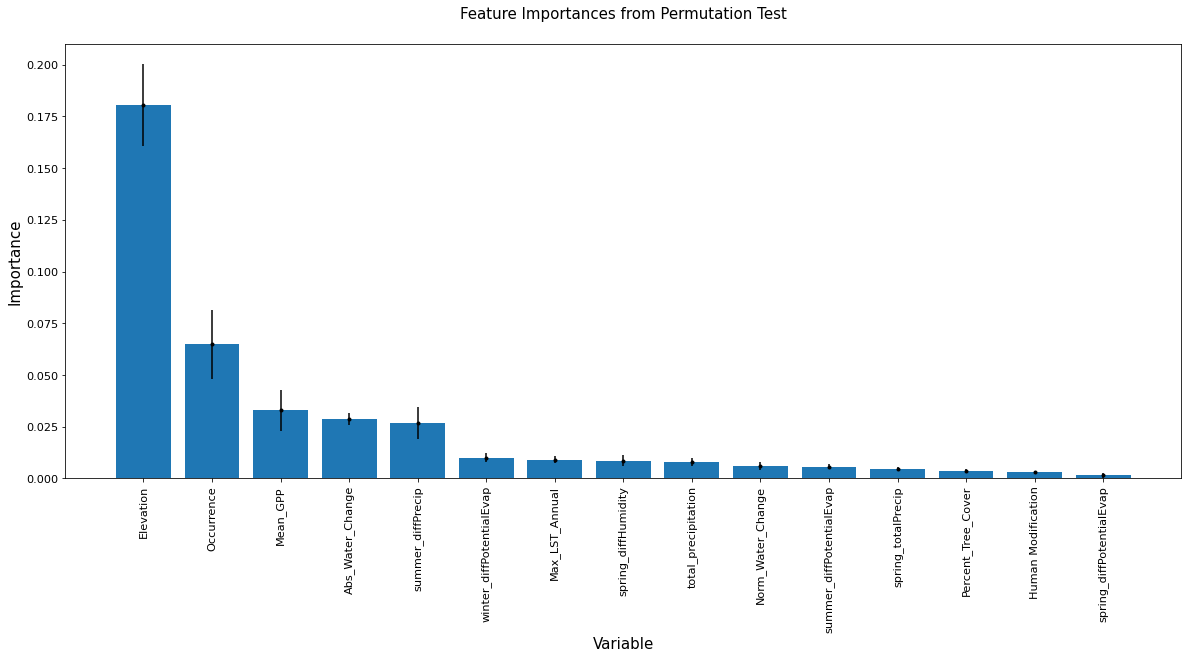

In [177]:
perm_imp_first = perm_imp_df.sort_values('feature_importance')[:15]
xs = perm_imp_first.index
impact = perm_imp_first['feature_importance']
variable = perm_imp_first['feature']

plt.bar(xs, impact, orientation = 'vertical')
plt.errorbar(xs, impact, c = 'black',yerr = perm_imp_first['feat_imp_sd'], fmt = '.')

plt.xticks(xs, variable, rotation = 'vertical')

plt.ylabel("Importance"); plt.xlabel("Variable"); plt.title("Feature Importances from Permutation Test")
plt.show()

In [178]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='feature'), dfs)
rename = ['Feature','Parr_Importance','Parr_Importance_SD',
          'Parr_Rank','Perm_Importance', "Perm_Importance_SD",
          'Perm_Rank','DropColumns_Importance','Drop_Rank']
df_final = df_final.rename(columns = dict(zip(df_final.columns,rename))) \
                    .sort_values("Perm_Importance",ascending = False) \
                    .reset_index(drop=True)

In [123]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

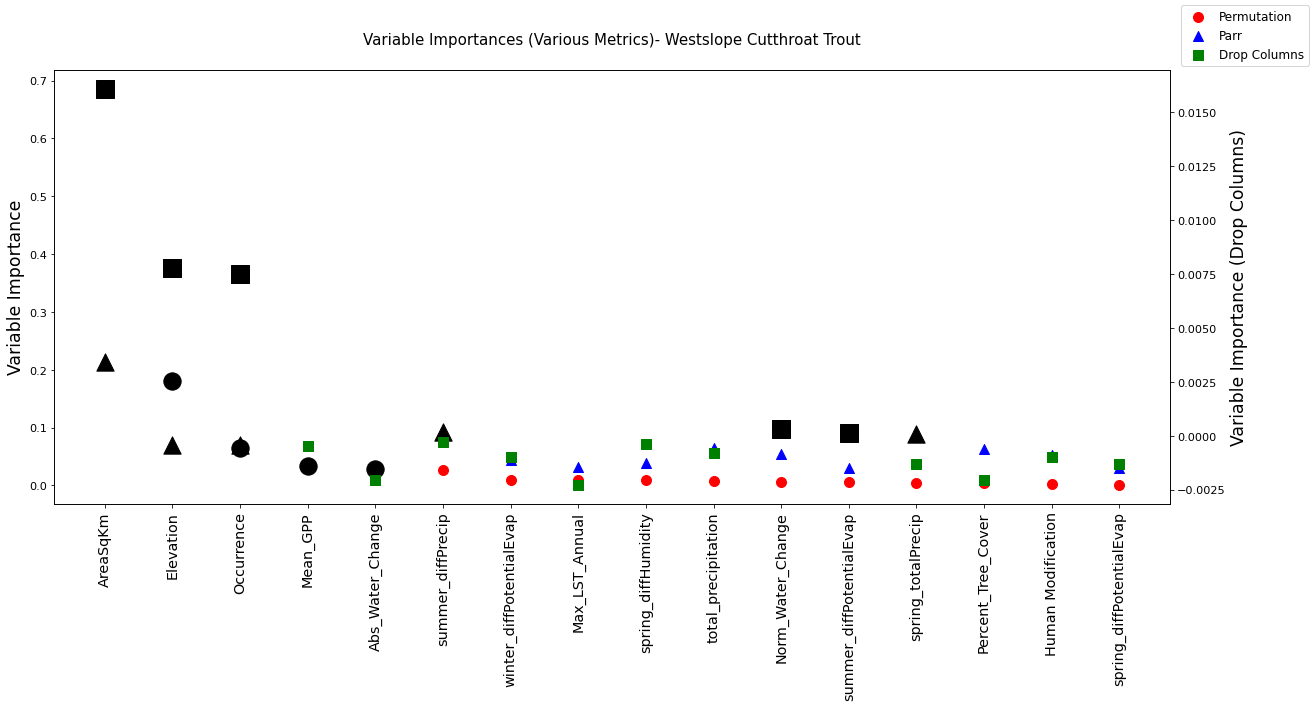

In [179]:
top_parr = df_final[['Parr_Importance','Feature']]\
                .sort_values('Parr_Importance', ascending = False)[:5]
top_perm = df_final[['Perm_Importance','Feature']]\
                .sort_values('Perm_Importance', ascending = False)[:5]
top_drop = df_final[['DropColumns_Importance','Feature']]\
                .sort_values('DropColumns_Importance', ascending = False)[:5]

fig,ax1 = plt.subplots()




#Set Axis Labels and Ticks
ax1.set_xticks(df_final.index, minor=False)
ax1.set_xticklabels(df_final['Feature'],rotation = 'vertical',fontsize = 'x-large')
ax1.set_ylabel("Variable Importance", fontsize='xx-large')

#Add Parr and Perm Importance to graph
ax1.scatter(df_final['Feature'],df_final['Perm_Importance'], 
             c = 'r', s = 100, marker = 'o', label = "Permutation")
ax1.scatter(df_final['Feature'],df_final['Parr_Importance'], 
            c = 'b', s = 100, marker = '^', label = "Parr")


#Set Drop Columns on Different axis
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel("Variable Importance (Drop Columns)", fontsize='xx-large')


ax2.scatter(df_final['Feature'],df_final['DropColumns_Importance'], 
            c = 'g', marker = 's', s = 100, label = "Drop Columns")
ax2.scatter(top_drop['Feature'],top_drop['DropColumns_Importance'], 
            c = 'black', s = 300, marker = 's')




#Embolden 5 top features
ax1.scatter(top_perm['Feature'],top_perm['Perm_Importance'], 
             c = 'black', s = 300, marker = 'o')
ax1.scatter(top_parr['Feature'],top_parr['Parr_Importance'], 
            c = 'black', s = 300, marker = '^')






#Set Axis labels and Title
plt.xlabel("Variable", fontsize = 20)
plt.title("Variable Importances (Various Metrics)- Westslope Cutthroat Trout")



new_handles_1 = (ax1.get_legend_handles_labels()[0][:2],ax1.get_legend_handles_labels()[1][:2])
new_handles_2 = (ax2.get_legend_handles_labels()[0][:1],ax2.get_legend_handles_labels()[1][:1])
handles, labels = [(a + b) for a, b in zip(new_handles_1, new_handles_2)]
fig.legend(handles,labels, loc='upper right')

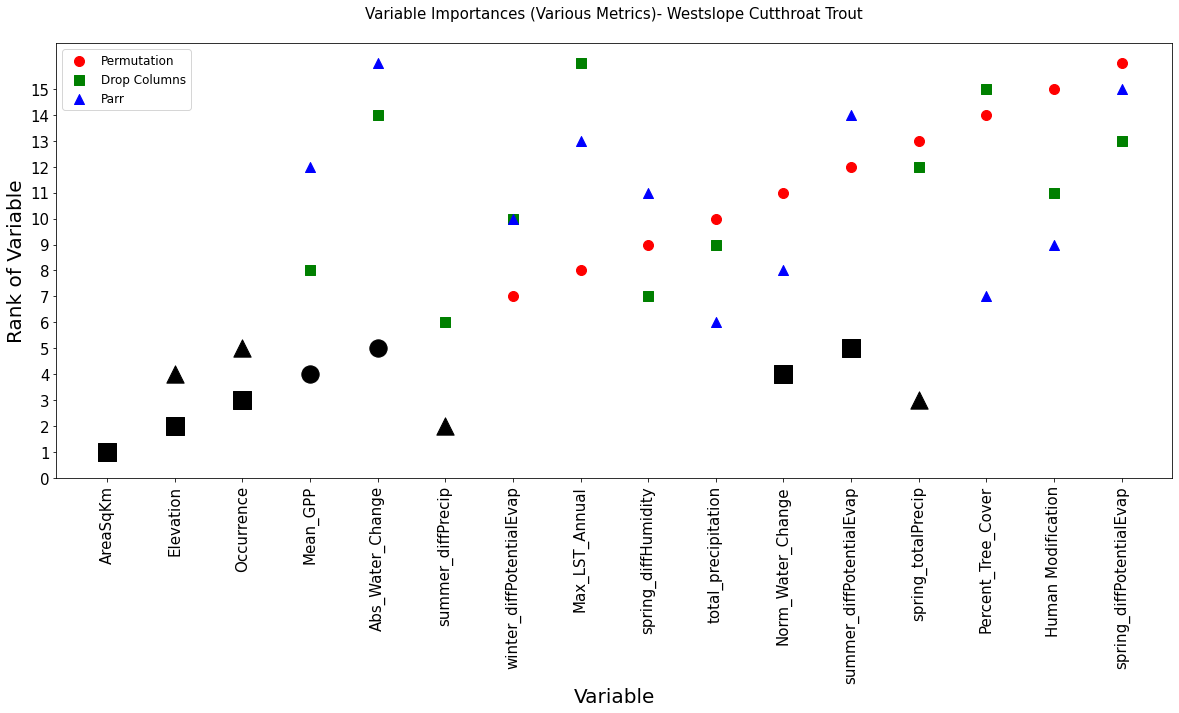

In [126]:
top_parr = df_final[['Parr_Rank','Feature']]\
                .sort_values('Parr_Rank', ascending = True)[:5]
top_perm = df_final[['Perm_Rank','Feature']]\
                .sort_values('Perm_Rank', ascending = True)[:5]
top_drop = df_final[['Drop_Rank','Feature']]\
                .sort_values('Drop_Rank', ascending = True)[:5]



#Plot three different Ranks
perm=plt.scatter(df_final['Feature'],df_final['Perm_Rank'], 
             c = 'r', s = 100, marker = 'o', label = "Permutation")
drop=plt.scatter(df_final['Feature'],df_final['Drop_Rank'], 
            c = 'g',s = 100, marker = 's', label = "Drop Columns")
parr=plt.scatter(df_final['Feature'],df_final['Parr_Rank'], 
            c = 'b', s = 100, marker = '^', label = "Parr")

#Embolden 5 top features
#Embolden 5 top features
plt.scatter(top_perm['Feature'],top_perm['Perm_Rank'], 
             c = 'black', s = 300, marker = 'o')
plt.scatter(top_parr['Feature'],top_parr['Parr_Rank'], 
            c = 'black', s = 300, marker = '^')
plt.scatter(top_drop['Feature'],top_drop['Drop_Rank'], 
            c = 'black', s = 300, marker = 's')



#Mess with axis ticks
plt.xticks(df_final.index, df_final['Feature'], rotation = 'vertical', fontsize = 15)
plt.yticks(df_final.index, fontsize = 15)





#Mess with Title and Axis labels
plt.ylabel("Rank of Variable", fontsize = 20)
plt.xlabel("Variable", fontsize = 20)
plt.title("Variable Importances (Various Metrics)- Westslope Cutthroat Trout")
plt.legend(handles=[perm,drop,parr])

In [127]:
df_final[["Parr_Importance","Perm_Importance","DropColumns_Importance"]].corr()

Parr_Importance  Perm_Importance  \
Parr_Importance                1.000000         0.886812   
Perm_Importance                0.886812         1.000000   
DropColumns_Importance         0.801970         0.900889   

                        DropColumns_Importance  
Parr_Importance                       0.801970  
Perm_Importance                       0.900889  
DropColumns_Importance                1.000000

In [128]:
df_final.columns

Index(['Feature', 'Parr_Importance', 'Parr_Importance_SD', 'Parr_Rank',
       'Perm_Importance', 'Perm_Importance_SD', 'Perm_Rank',
       'DropColumns_Importance', 'Drop_Rank'],
      dtype='object')

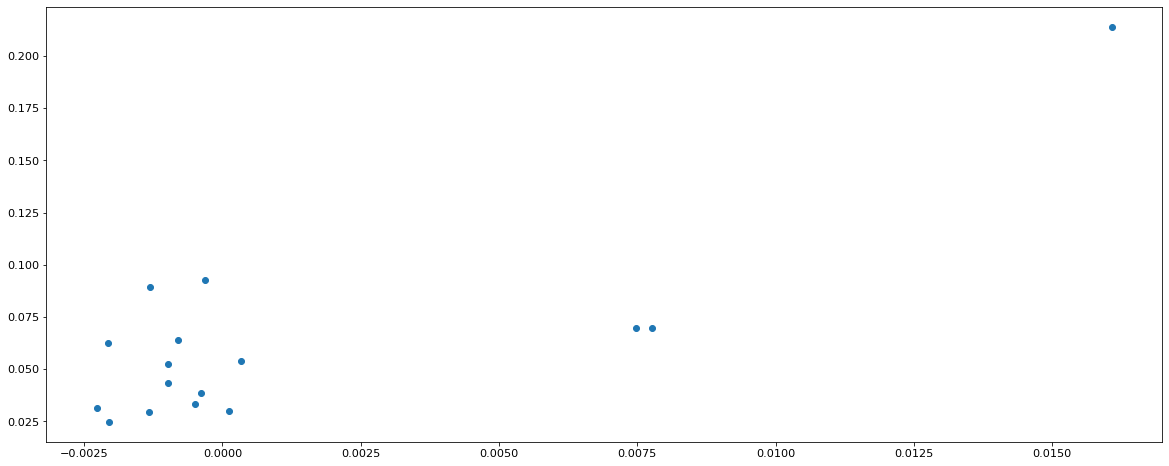

In [131]:
parr = df_final['Parr_Importance']
perm = df_final['Perm_Importance']
col = df_final['DropColumns_Importance']

plt.plot(col,parr, 'o')


## Rainbow Trout

In [192]:
#//========================================================
#RBT========================================================
#//========================================================

X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)
rbt_rf = RandomForestRegressor(n_estimators = 600, oob_score = True,random_state = 3)
rbt_rf.fit(X_train,y_train)



RandomForestRegressor(n_estimators=600, oob_score=True, random_state=3)

In [133]:
rbt_imp = importances(X = X_rbt_collinear,
                      y = y_rbt, 
                      n_trees = 100, 
                      n_trials = 50,
                      min_samples_leaf = 15,
                      n_jobs = -1)


PARAMETERS:
	n=|X|                132
	n_trials             50
	min_samples_leaf     15
	cat_min_samples_leaf 5
	min_slopes_per_x     5
	bootstrap            True
	n_trees              100
Impact importance time 9s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 4s
Impact importance time 4s
Impact importance time 4s
Impact importance time 3s
Impact importance time 3s
Impact importance time 4s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 4s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impact importance time 3s
Impac

In [134]:
rbt_imp.sort_values(['Importance'], ascending = False)

Importance  Importance sigma    Impact  \
Feature                                                             
Elevation                    0.116511          0.021795  0.115835   
spring_diffPrecip            0.050402          0.028753  0.050243   
winter_diffPotentialEvap     0.041432          0.026429  0.041361   
winter_totalPrecip           0.039253          0.020410  0.039116   
winter_diffPrecip            0.037557          0.022154  0.037521   
spring_totalPrecip           0.035723          0.030370  0.035514   
Lithology                    0.035581          0.014453  0.036428   
gHM                          0.031170          0.018560  0.031130   
summer_diffHumidity          0.030665          0.019092  0.030569   
total_precipitation          0.029014          0.019755  0.028840   
Occurrence                   0.028190          0.020665  0.028083   
winter_totalPotentialEvap    0.027323          0.016659  0.027313   
Norm_Water_Change            0.025954          0.015916  0.025882   
summer_diffPrecip            0.025574          0.017717  0.025677   
summer_totalPotentialEvap    0.023176          0.014382  0.023210   
Heat-Insolation Load         0.022584          0.010227  0.023492   
summer_diffPotentialEvap     0.022511          0.013827  0.022499   
Percent_Tree_Cover           0.022358          0.015629  0.022305   
Abs_Water_Change             0.022227          0.016277  0.022107   
Mean_EVI                     0.022077          0.012835  0.022027   
Human Modification           0.021779          0.012715  0.021981   
occurrence                   0.021677          0.011649  0.021446   
winter_diffHumidity          0.021222          0.012116  0.021116   
Mean_GPP                     0.020694          0.011676  0.020675   
winter_diffTemp              0.020659          0.010970  0.020557   
Topographic Diversity        0.020220          0.008935  0.020610   
spring_totalPotentialEvap    0.020173          0.011017  0.020023   
AreaSqKm                     0.019449          0.013682  0.019397   
spring_diffHumidity          0.019349          0.009770  0.019510   
spring_diffTemp              0.019279          0.011897  0.019249   
HUCID                        0.018946          0.010813  0.018817   
Max_LST_Annual               0.018692          0.009135  0.018694   
spring_diffPotentialEvap     0.018128          0.011597  0.018231   
fall_totalPotentialEvap      0.017538          0.009617  0.017512   
Recurrence                   0.016553          0.012815  0.016649   
summer_diffTemp              0.016359          0.008449  0.016382   

                           Impact sigma  
Feature                                  
Elevation                      0.022399  
spring_diffPrecip              0.028347  
winter_diffPotentialEvap       0.026248  
winter_totalPrecip             0.020484  
winter_diffPrecip              0.021998  
spring_totalPrecip             0.030167  
Lithology                      0.013976  
gHM                            0.017708  
summer_diffHumidity            0.018887  
total_precipitation            0.019491  
Occurrence                     0.020510  
winter_totalPotentialEvap      0.016532  
Norm_Water_Change              0.015410  
summer_diffPrecip              0.017625  
summer_totalPotentialEvap      0.014352  
Heat-Insolation Load           0.010524  
summer_diffPotentialEvap       0.013726  
Percent_Tree_Cover             0.015662  
Abs_Water_Change               0.016539  
Mean_EVI                       0.012923  
Human Modification             0.012926  
occurrence                     0.011417  
winter_diffHumidity            0.012049  
Mean_GPP                       0.011571  
winter_diffTemp                0.010870  
Topographic Diversity          0.008611  
spring_totalPotentialEvap      0.010895  
AreaSqKm                       0.012891  
spring_diffHumidity            0.009735  
spring_diffTemp                0.011886  
HUCID                          0.010694  
Max_LST_Annual    

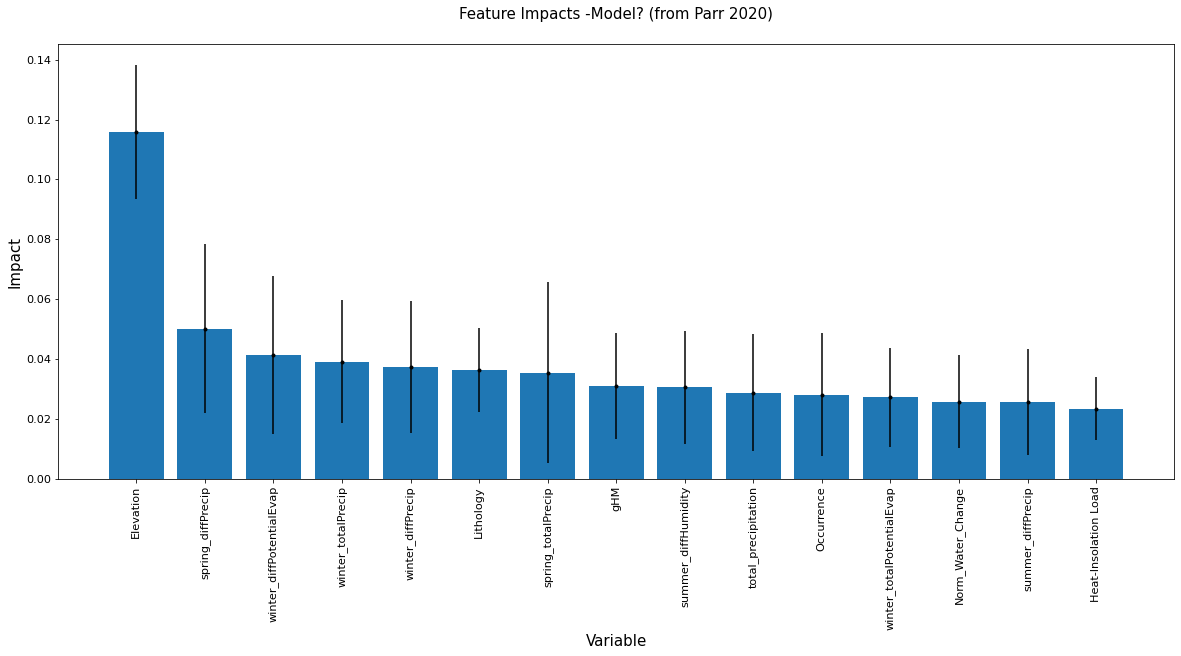

In [135]:
rbt_imp_first = rbt_imp.sort_values("Impact",ascending = False)[:15]#.reset_index(drop=False)
xs = rbt_imp_first.index
impact = rbt_imp_first['Impact']
variable = rbt_imp_first.index
rbt_imp_first['feature'] = variable

plt.bar(xs, impact, orientation = 'vertical')
plt.errorbar(xs, impact, c = 'black',yerr = rbt_imp_first['Impact sigma'], fmt = '.')

plt.xticks(xs, variable, rotation = 'vertical')

plt.ylabel("Impact"); plt.xlabel("Variable"); plt.title("Feature Impacts -Model? (from Parr 2020)")
plt.show()

In [136]:
#Do not run-- drop column analysis
drop_col_rbt = drop_col(rbt_rf, X_train, y_train, random_state = 10)

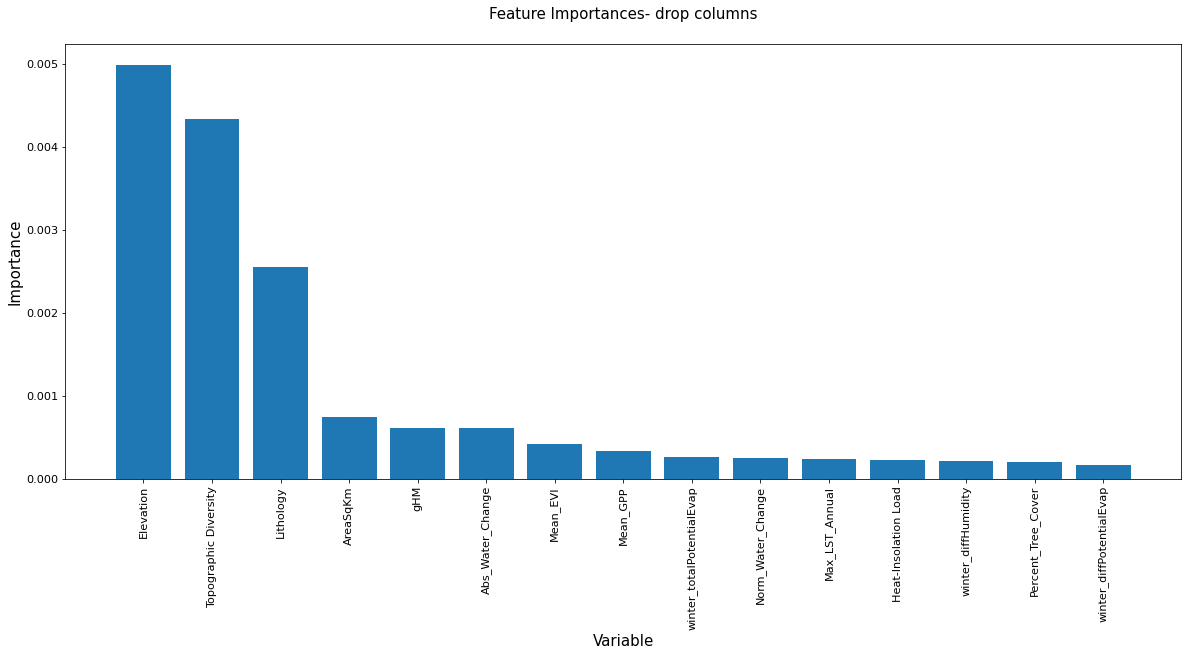

In [137]:
drop_col_rbt_first = drop_col_rbt.sort_values("feature_importance",ascending = False)[:15]#.reset_index(drop=False)
xs = drop_col_rbt_first.index
impact = drop_col_rbt_first['feature_importance']
variable = drop_col_rbt_first.index
drop_col_rbt_first['feature']

plt.bar(xs, impact, orientation = 'vertical')

plt.xticks(xs, drop_col_rbt_first['feature'], rotation = 'vertical')

plt.ylabel("Importance"); plt.xlabel("Variable"); plt.title("Feature Importances- drop columns")
plt.show()

In [138]:
#Do not run- permutation importance
X_train, X_test, y_train, y_test = train_test_split(X_rbt_collinear,
                                                y_rbt,
                                                test_size = 0.2, 
                                                random_state = 3)
perm_rbt = permutation_importance(rbt_rf, X_train, y_train, n_repeats = 30, random_state = 10)

In [139]:
par_imp_rbt = par_imp_rbt[['feature','Importance','Importance sigma']] \
            .rename(columns = dict(zip(par_imp.columns,['feature','feature_importance','importance_sd']))) \
            .sort_values("Importance",ascending = False)
perm_imp_rbt = pd.DataFrame({"feature": X_train.columns,
                           "feature_importance": perm_rbt.importances_mean,
                           "feat_imp_sd": perm_rbt.importances_std}) \
                        .sort_values('feature_importance',ascending = False).reset_index(drop=True)
drop_rbt = drop_col_rbt.sort_values('feature_importance',ascending = False).reset_index(drop=True)

dfs = [par_imp_rbt,perm_imp_rbt,drop_rbt]

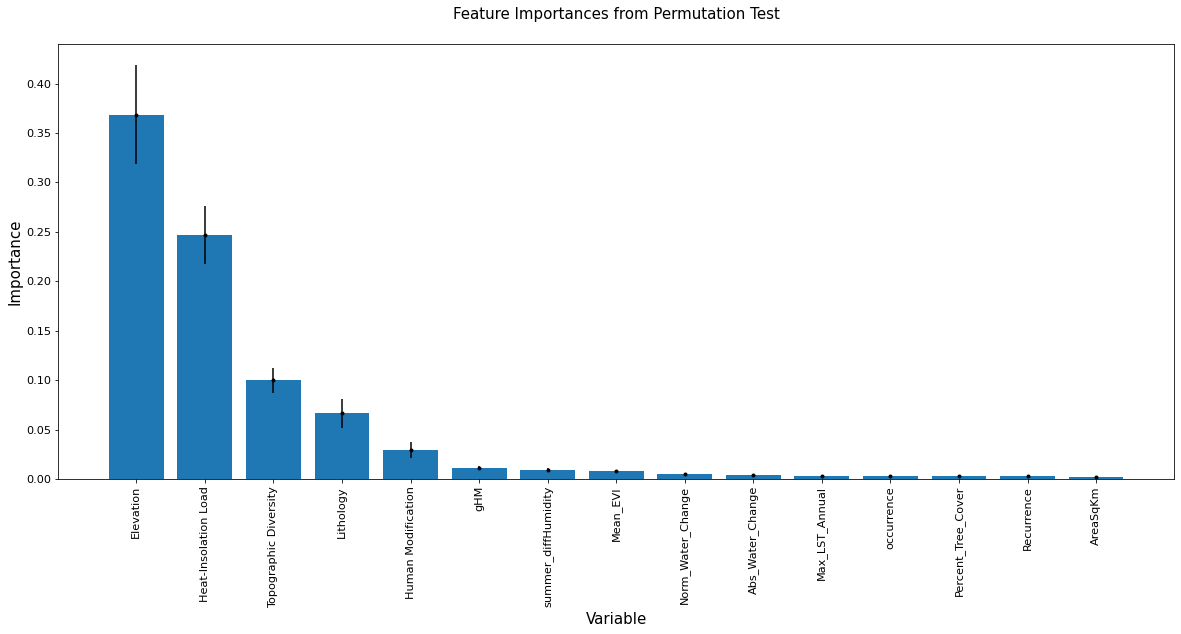

In [140]:
perm_imp_rbt_first = perm_imp_rbt.sort_values("feature_importance", ascending = False)[:15]
xs = perm_imp_rbt_first.index
impact = perm_imp_rbt_first['feature_importance']
variable = perm_imp_rbt_first['feature']

plt.bar(xs, impact, orientation = 'vertical')
plt.errorbar(xs, impact, c = 'black',yerr = perm_imp_rbt_first['feat_imp_sd'], fmt = '.')

plt.xticks(xs, variable, rotation = 'vertical')

plt.ylabel("Importance"); plt.xlabel("Variable"); plt.title("Feature Importances from Permutation Test")
plt.show()

### Construct dataframe and comparitive plots

In [193]:
#Append rank to each data frame
def give_rank(df):
    df['rank'] = np.arange(1,len(df)+1)
    return df


par_imp_rbt = give_rank(par_imp_rbt)
perm_imp_rbt = give_rank(perm_imp_rbt)
drop_col_rbt = give_rank(drop_col_rbt)

dfs = [par_imp_rbt,perm_imp_rbt,drop_col_rbt]

In [194]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='feature'), dfs)
rename = ['Feature','Parr_Importance','Parr_Importance_SD',
          'Parr_Rank','Perm_Importance', "Perm_Importance_SD",
          'Perm_Rank','DropColumns_Importance','Drop_Rank']
df_final = df_final.rename(columns = dict(zip(df_final.columns,rename))) \
                    .sort_values("Perm_Importance",ascending = False) \
                    .reset_index(drop=True)

In [195]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

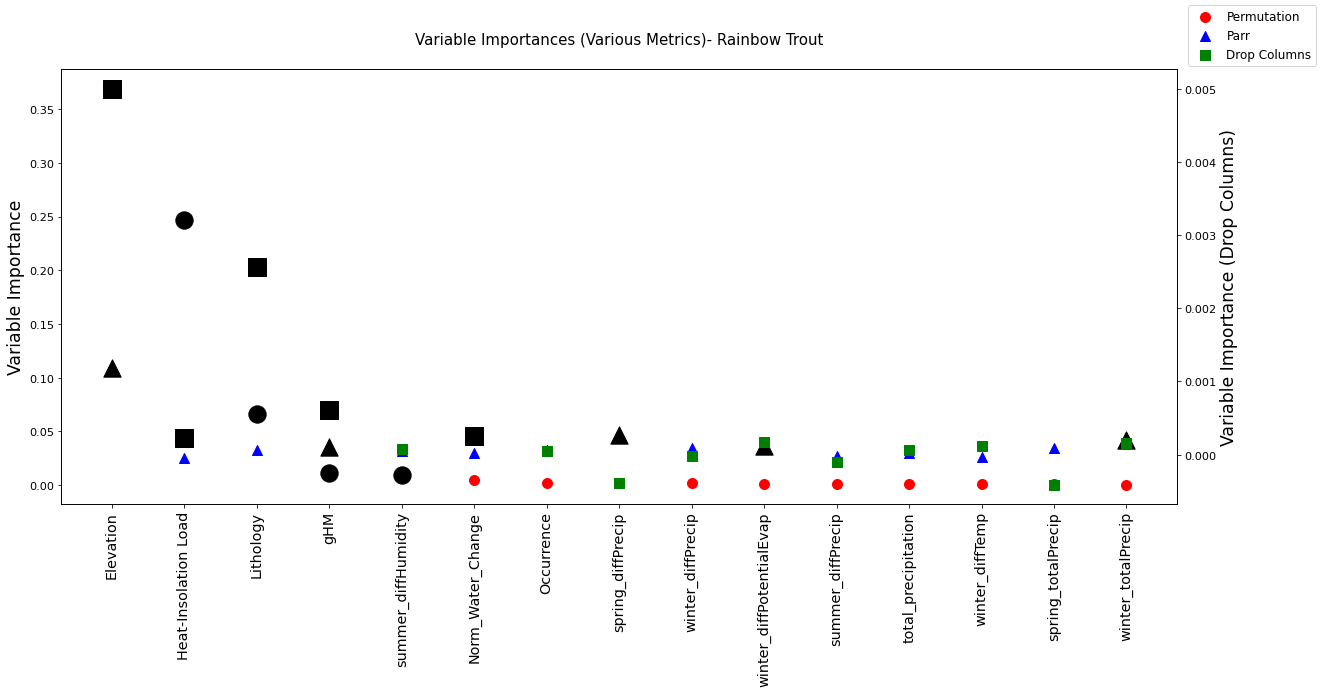

In [196]:
top_parr = df_final[['Parr_Importance','Feature']]\
                .sort_values('Parr_Importance', ascending = False)[:5]
top_perm = df_final[['Perm_Importance','Feature']]\
                .sort_values('Perm_Importance', ascending = False)[:5]
top_drop = df_final[['DropColumns_Importance','Feature']]\
                .sort_values('DropColumns_Importance', ascending = False)[:5]

fig,ax1 = plt.subplots()




#Set Axis Labels and Ticks
ax1.set_xticks(df_final.index, minor=False)
ax1.set_xticklabels(df_final['Feature'],rotation = 'vertical',fontsize = 'x-large')
ax1.set_ylabel("Variable Importance", fontsize='xx-large')

#Add Parr and Perm Importance to graph
ax1.scatter(df_final['Feature'],df_final['Perm_Importance'], 
             c = 'r', s = 100, marker = 'o', label = "Permutation")
ax1.scatter(df_final['Feature'],df_final['Parr_Importance'], 
            c = 'b', s = 100, marker = '^', label = "Parr")


#Set Drop Columns on Different axis
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel("Variable Importance (Drop Columns)", fontsize='xx-large')


ax2.scatter(df_final['Feature'],df_final['DropColumns_Importance'], 
            c = 'g', marker = 's', s = 100, label = "Drop Columns")
ax2.scatter(top_drop['Feature'],top_drop['DropColumns_Importance'], 
            c = 'black', s = 300, marker = 's')




#Embolden 5 top features
ax1.scatter(top_perm['Feature'],top_perm['Perm_Importance'], 
             c = 'black', s = 300, marker = 'o')
ax1.scatter(top_parr['Feature'],top_parr['Parr_Importance'], 
            c = 'black', s = 300, marker = '^')






#Set Axis labels and Title
plt.xlabel("Variable", fontsize = 20)
plt.title("Variable Importances (Various Metrics)- Rainbow Trout")



new_handles_1 = (ax1.get_legend_handles_labels()[0][:2],ax1.get_legend_handles_labels()[1][:2])
new_handles_2 = (ax2.get_legend_handles_labels()[0][:1],ax2.get_legend_handles_labels()[1][:1])
handles, labels = [(a + b) for a, b in zip(new_handles_1, new_handles_2)]
fig.legend(handles,labels, loc='upper right')

In [145]:
df_final.shape

(15, 9)

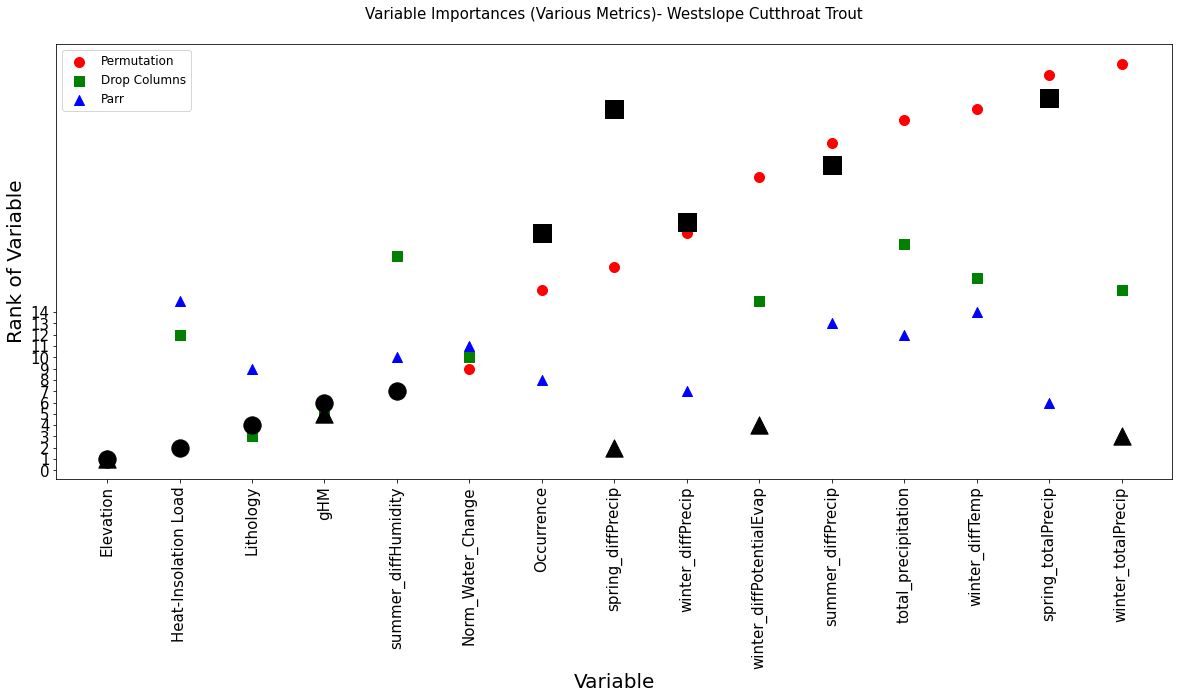

In [146]:
top_parr = df_final[['Parr_Rank','Feature']]\
                .sort_values('Parr_Rank', ascending = True)[:5]
top_perm = df_final[['Perm_Rank','Feature']]\
                .sort_values('Perm_Rank', ascending = True)[:5]
top_drop = df_final[['Drop_Rank','Feature']]\
                .sort_values('Drop_Rank', ascending = False)[:5]



#Plot three different Ranks
perm=plt.scatter(df_final['Feature'],df_final['Perm_Rank'], 
             c = 'r', s = 100, marker = 'o', label = "Permutation")
drop=plt.scatter(df_final['Feature'],df_final['Drop_Rank'], 
            c = 'g',s = 100, marker = 's', label = "Drop Columns")
parr=plt.scatter(df_final['Feature'],df_final['Parr_Rank'], 
            c = 'b', s = 100, marker = '^', label = "Parr")

#Embolden 5 top features
#Embolden 5 top features
plt.scatter(top_perm['Feature'],top_perm['Perm_Rank'], 
             c = 'black', s = 300, marker = 'o')
plt.scatter(top_parr['Feature'],top_parr['Parr_Rank'], 
            c = 'black', s = 300, marker = '^')
plt.scatter(top_drop['Feature'],top_drop['Drop_Rank'], 
            c = 'black', s = 300, marker = 's')



#Mess with axis ticks
plt.xticks(df_final.index, df_final['Feature'], rotation = 'vertical', fontsize = 15)
plt.yticks(df_final.index, fontsize = 15)





#Mess with Title and Axis labels
plt.ylabel("Rank of Variable", fontsize = 20)
plt.xlabel("Variable", fontsize = 20)
plt.title("Variable Importances (Various Metrics)- Westslope Cutthroat Trout")
plt.legend(handles=[perm,drop,parr])

In [108]:
df_final.shape

(15, 9)

# Partial Dependency Plots for both models

## Westslope Cutthroat

### Parr

In [166]:
wct_pdp = csv_WCT.drop(['Percent_NonTree_Vegetation','Percent_NonVegetated','fall_totalPrecip'], axis=1)

In [182]:
# TOP PARR:
# AreaSqKm
# summer_diffPrecip
# spring_totalPrecip
# Elevation
# Occurrence



In [156]:
from pdpbox import pdp, get_dataset, info_plots


In [ ]:
top_drop

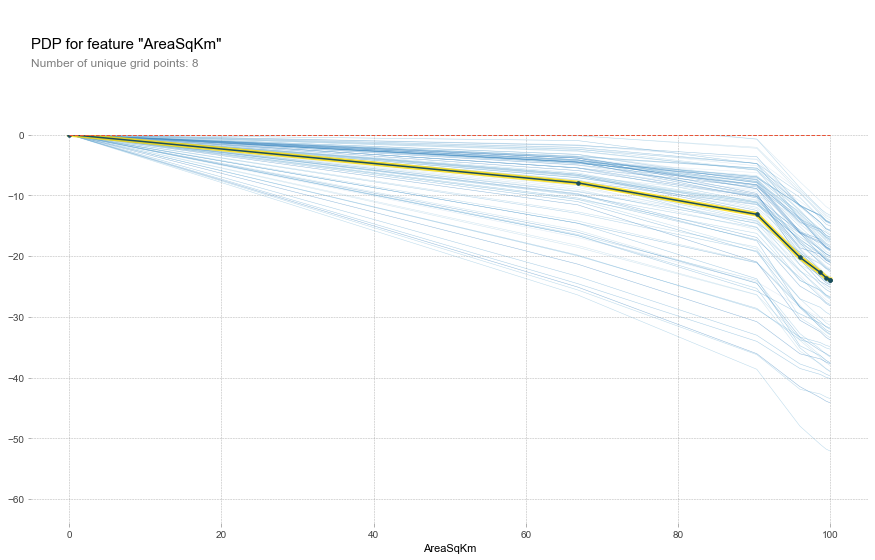

In [183]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='AreaSqKm'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'AreaSqKm', plot_lines=True, frac_to_plot=100)

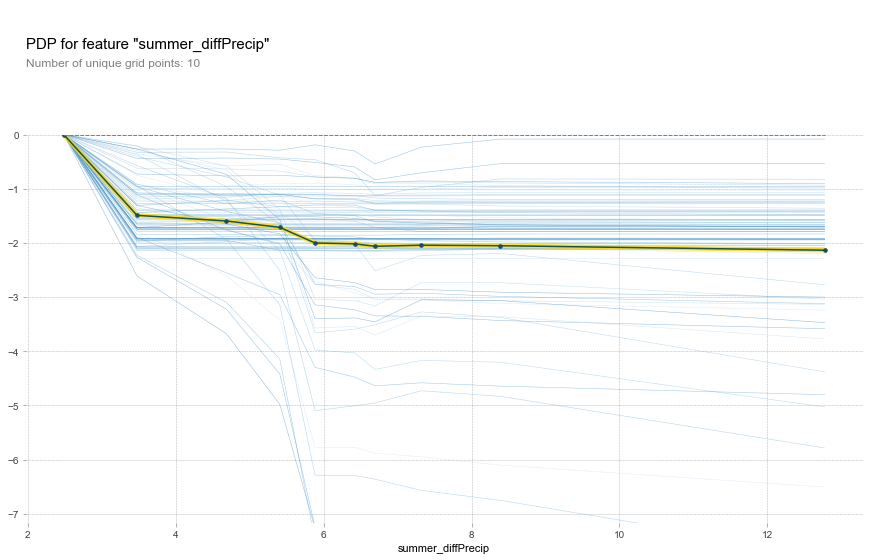

In [184]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='summer_diffPrecip'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'summer_diffPrecip', plot_lines=True, frac_to_plot=100)

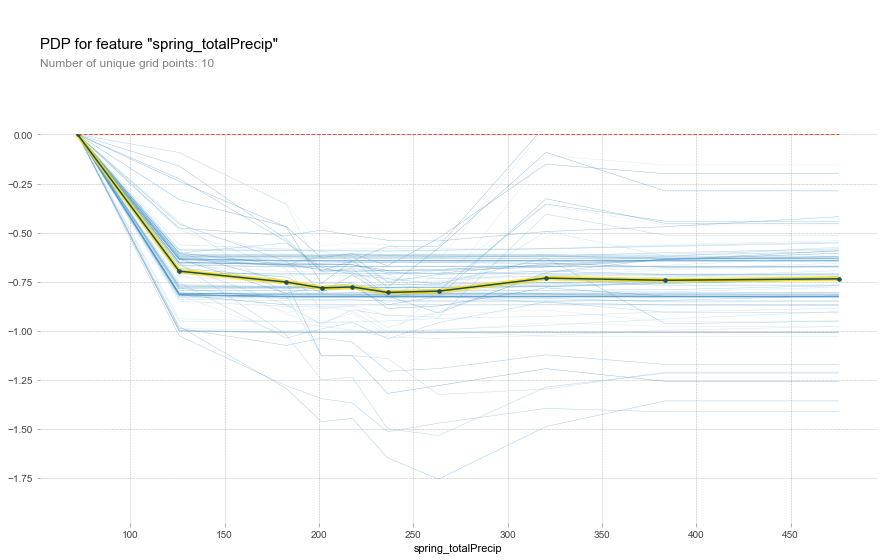

In [185]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='spring_totalPrecip'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'spring_totalPrecip', plot_lines=True, frac_to_plot=100)


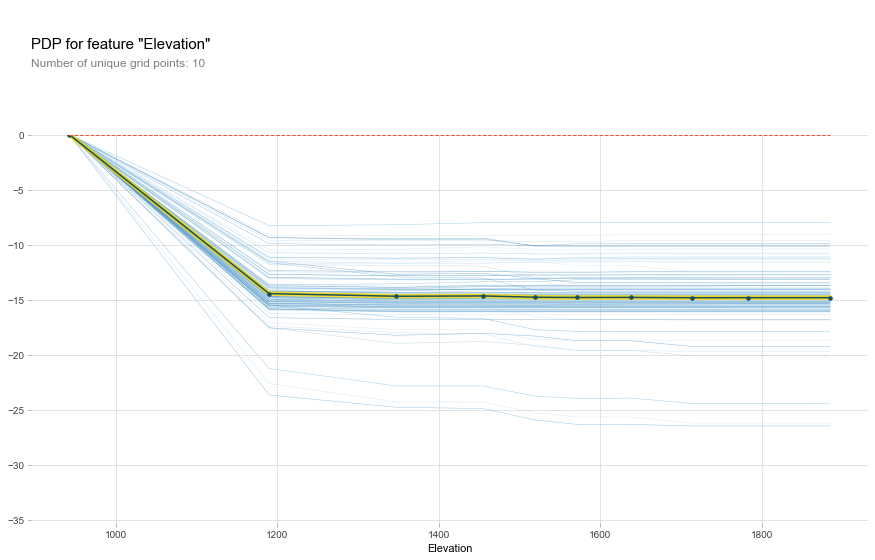

In [186]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='Elevation'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Elevation', plot_lines=True, frac_to_plot=100)

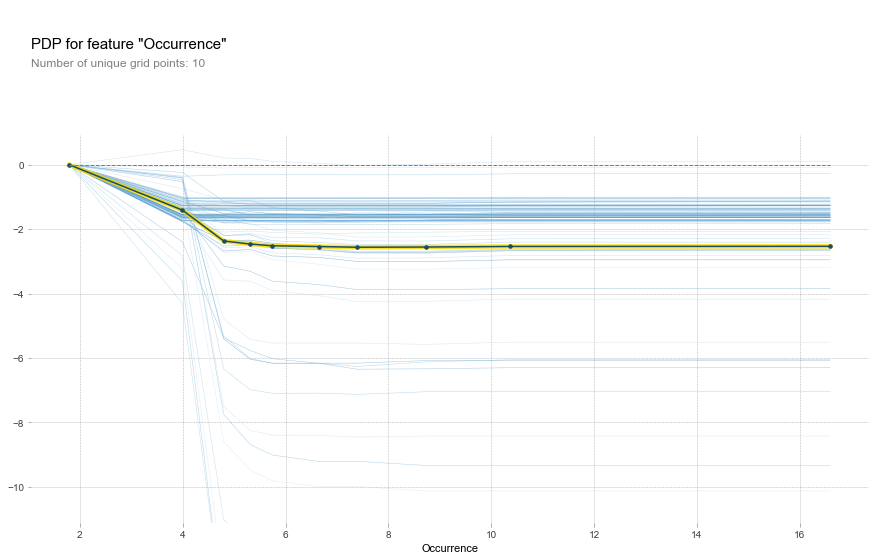

In [187]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='Occurrence'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Occurrence', plot_lines=True, frac_to_plot=100)


### Permutation

In [ ]:
# TOP PERM:
# AreaSqKm
# Elevation
# Occurrence
# Mean_GPP
# Abs_Water_Change

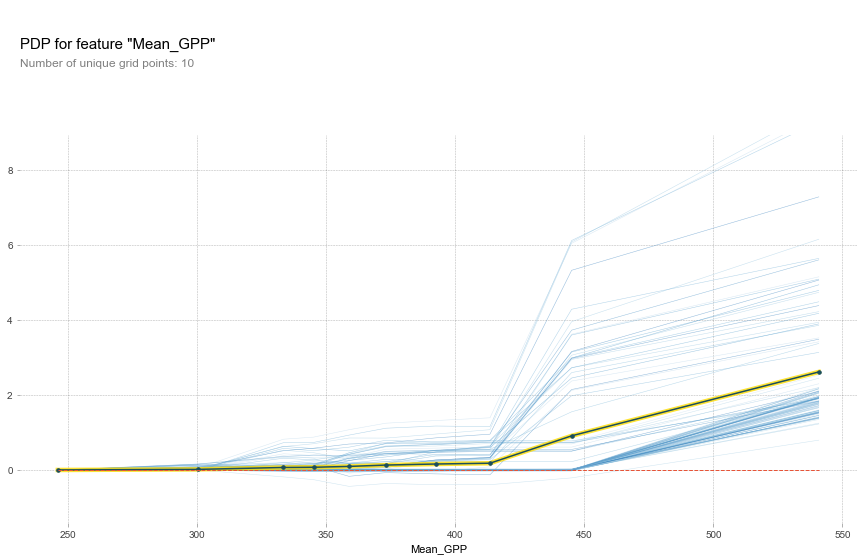

In [188]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='Mean_GPP'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Mean_GPP', plot_lines=True, frac_to_plot=100)

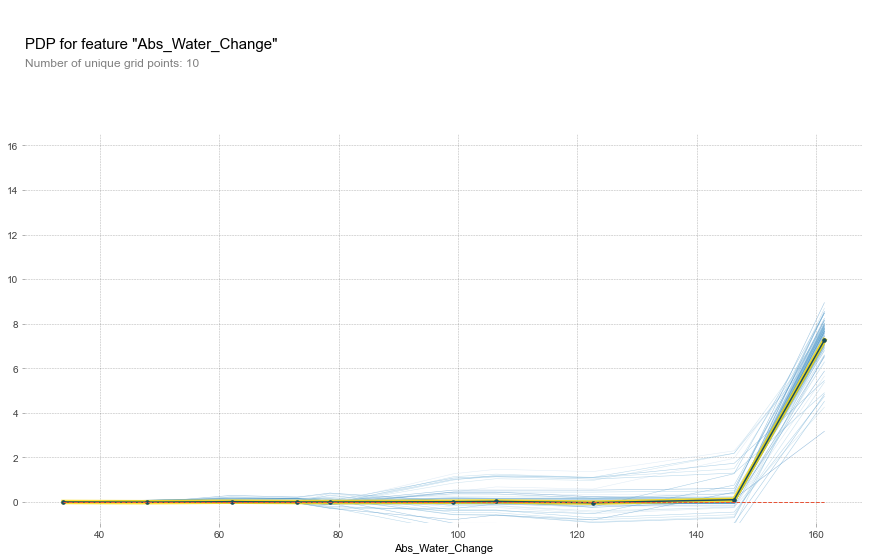

In [189]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='Abs_Water_Change'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Abs_Water_Change', plot_lines=True, frac_to_plot=100)

### Drop Columns

In [ ]:
# TOP DROP:
# AreaSqKm
# Elevation
# Occurrence
# Norm_Water_Change
# summer_diffPotentialEvap

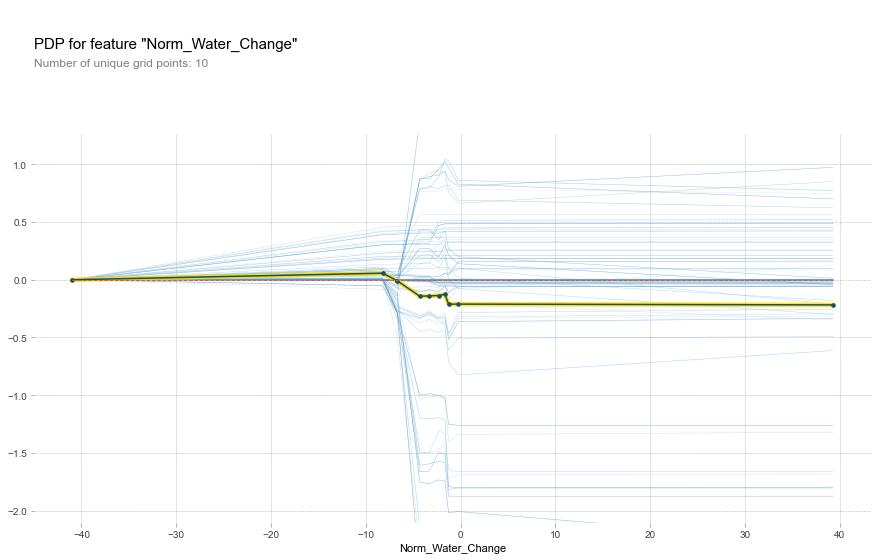

In [190]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='Norm_Water_Change'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Norm_Water_Change', plot_lines=True, frac_to_plot=100)


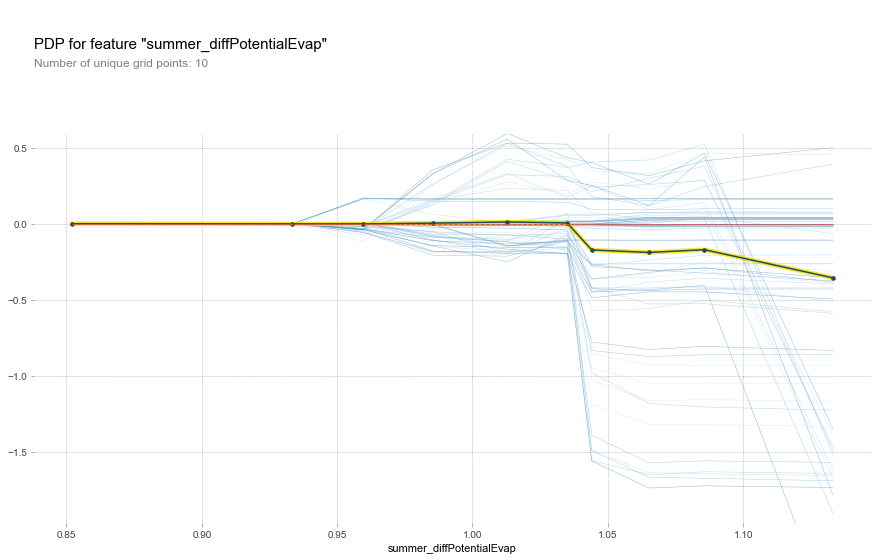

In [191]:
pdp_wct = pdp.pdp_isolate(
    model=wct_rf, dataset=wct_pdp, model_features=X_wct_collinear.columns, feature='summer_diffPotentialEvap'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'summer_diffPotentialEvap', plot_lines=True, frac_to_plot=100)


## Rainbow Trout

In [200]:
rbt_pdp = csv_RBT.drop(['Percent_NonTree_Vegetation','Percent_NonVegetated','fall_totalPrecip'], axis=1)

### Parr

In [198]:
Top Parr
# Elevation
# spring_diffPrecip
# winter_totalPrecip
# winter_diffPotentialEvap
# gHM

0                    Elevation
7            spring_diffPrecip
14          winter_totalPrecip
9     winter_diffPotentialEvap
3                          gHM
Name: Feature, dtype: object

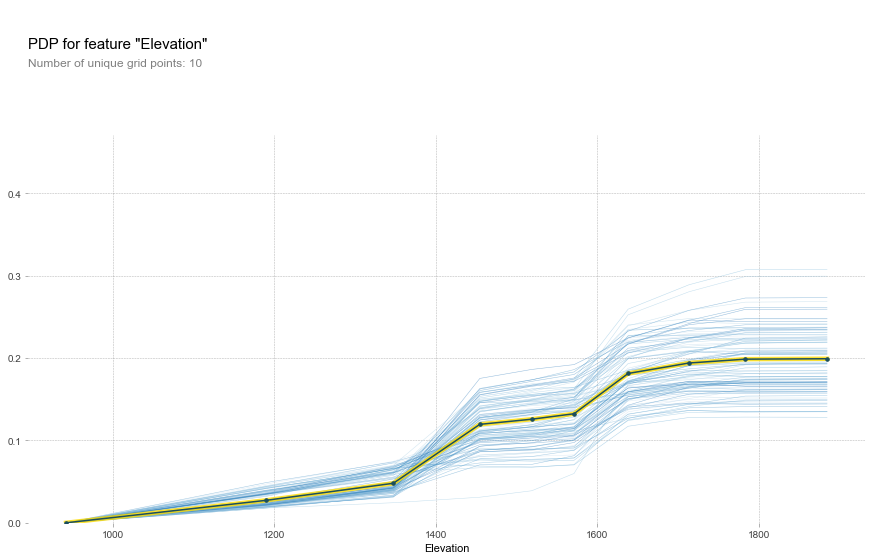

In [201]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='Elevation'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Elevation', plot_lines=True, frac_to_plot=100)


In [ ]:
partial_dep

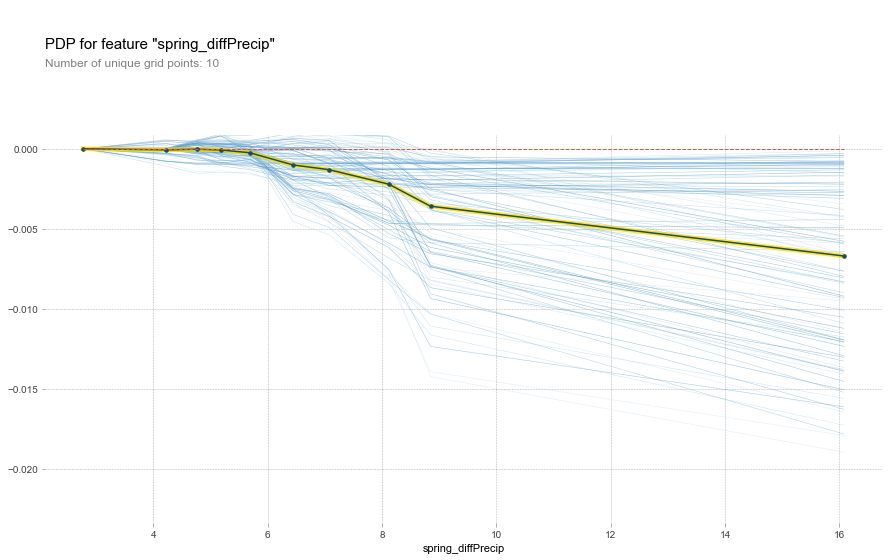

In [202]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='spring_diffPrecip'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'spring_diffPrecip', plot_lines=True, frac_to_plot=100)


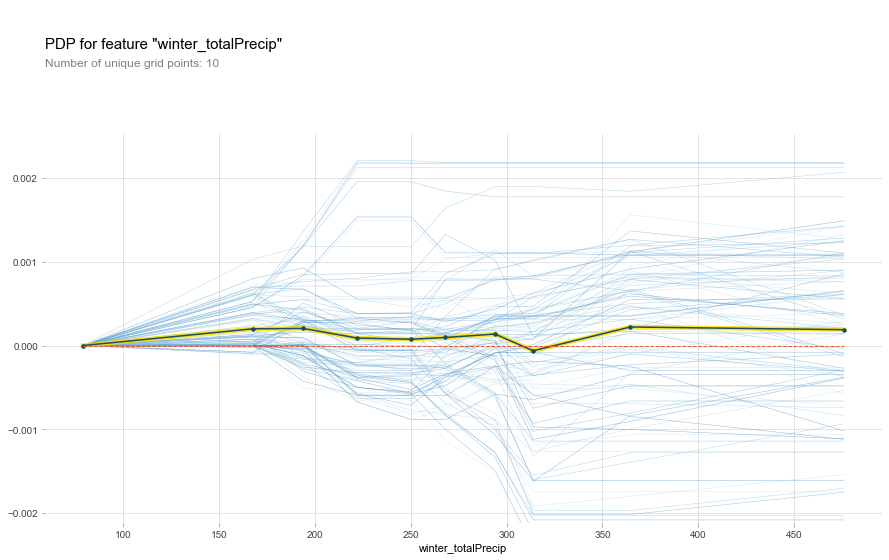

In [203]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='winter_totalPrecip'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'winter_totalPrecip', plot_lines=True, frac_to_plot=100)


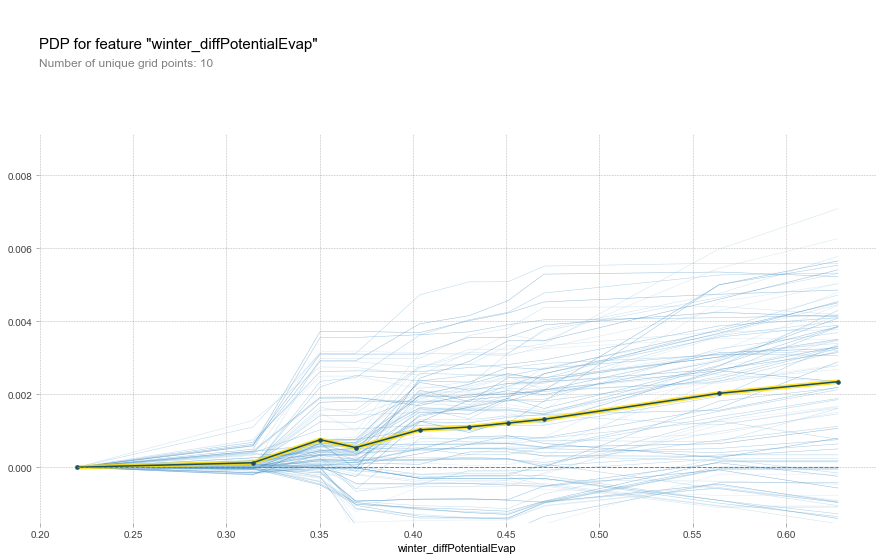

In [204]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='winter_diffPotentialEvap'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'winter_diffPotentialEvap', plot_lines=True, frac_to_plot=100)

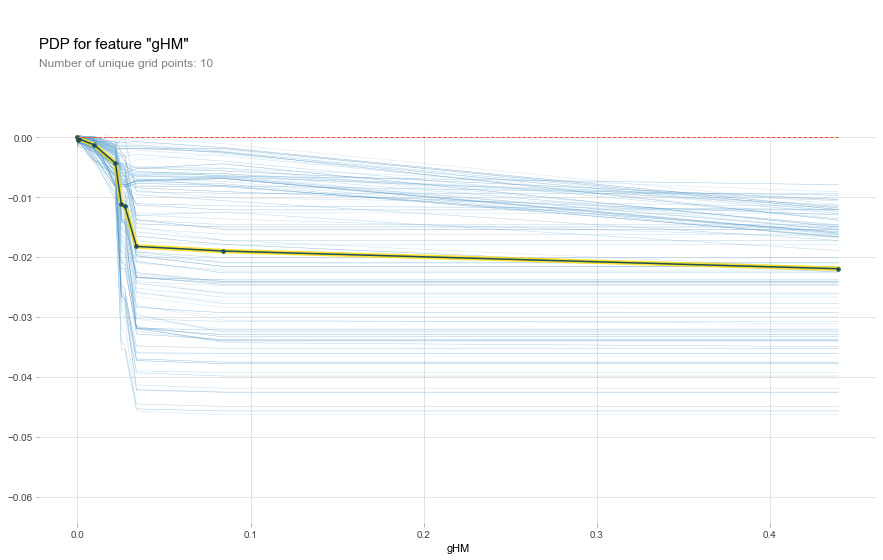

In [205]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='gHM'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'gHM', plot_lines=True, frac_to_plot=100)


### Permutation

In [207]:
#  Elevation
# Heat-Insolation Load
# Lithology
# gHM
# summer_diffHumidity

0               Elevation
1    Heat-Insolation Load
2               Lithology
3                     gHM
4     summer_diffHumidity
Name: Feature, dtype: object

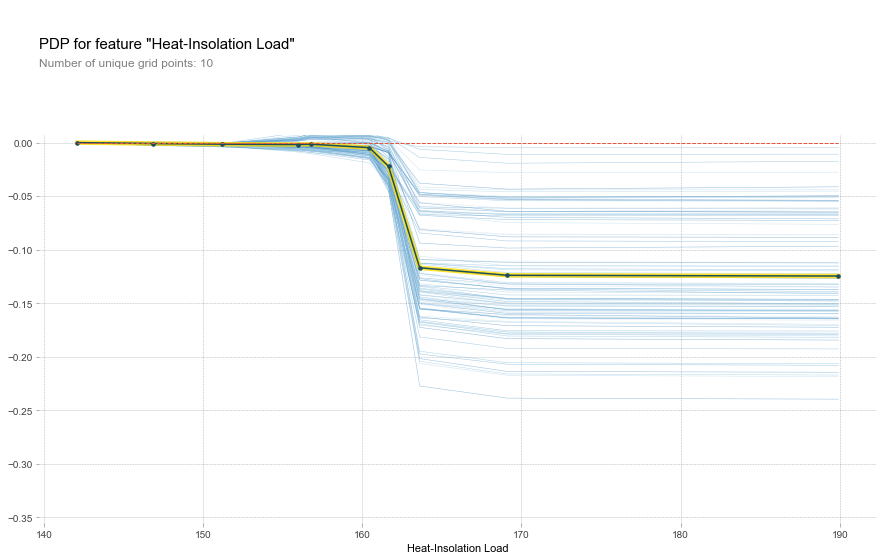

In [208]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='Heat-Insolation Load'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Heat-Insolation Load', plot_lines=True, frac_to_plot=100)



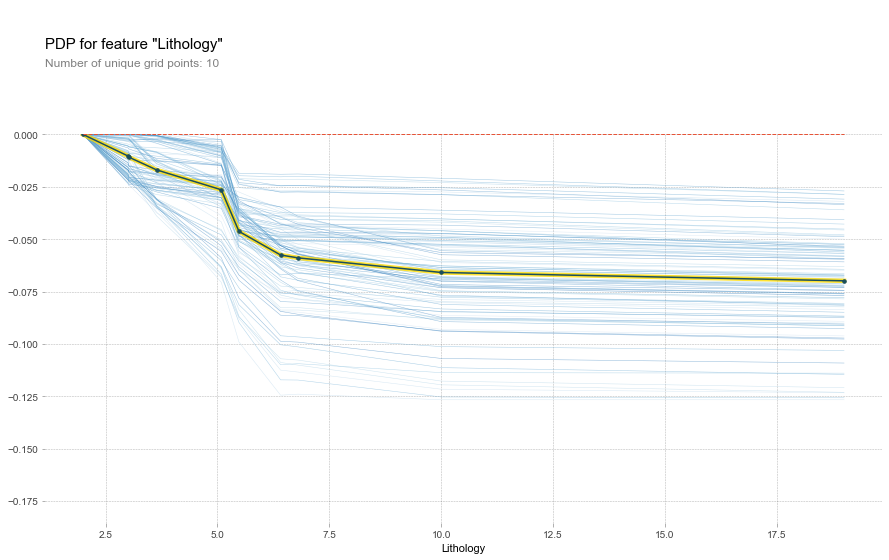

In [209]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='Lithology'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Lithology', plot_lines=True, frac_to_plot=100)



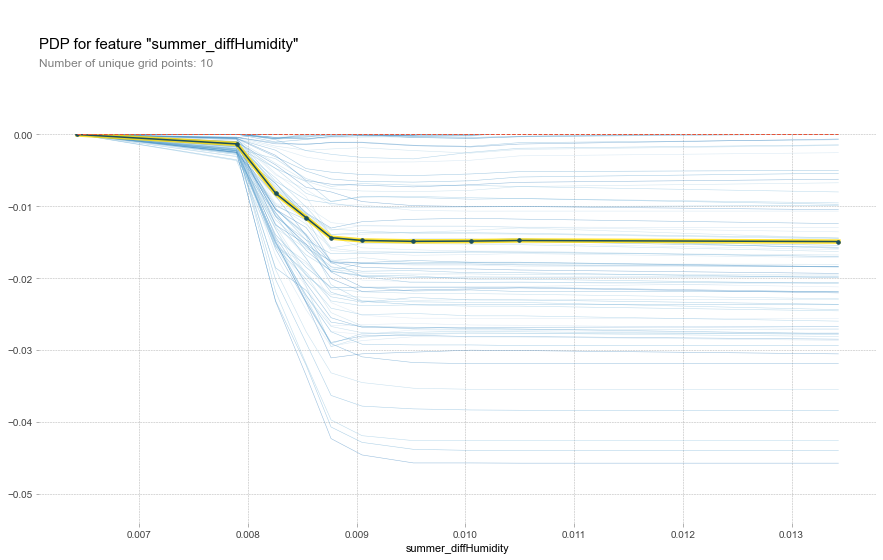

In [210]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='summer_diffHumidity'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'summer_diffHumidity', plot_lines=True, frac_to_plot=100)


### Drop Columns

In [212]:
# Elevation
# Lithology
# gHM
# Norm_Water_Change
# Heat-Insolation Load

0               Elevation
2               Lithology
3                     gHM
5       Norm_Water_Change
1    Heat-Insolation Load
Name: Feature, dtype: object

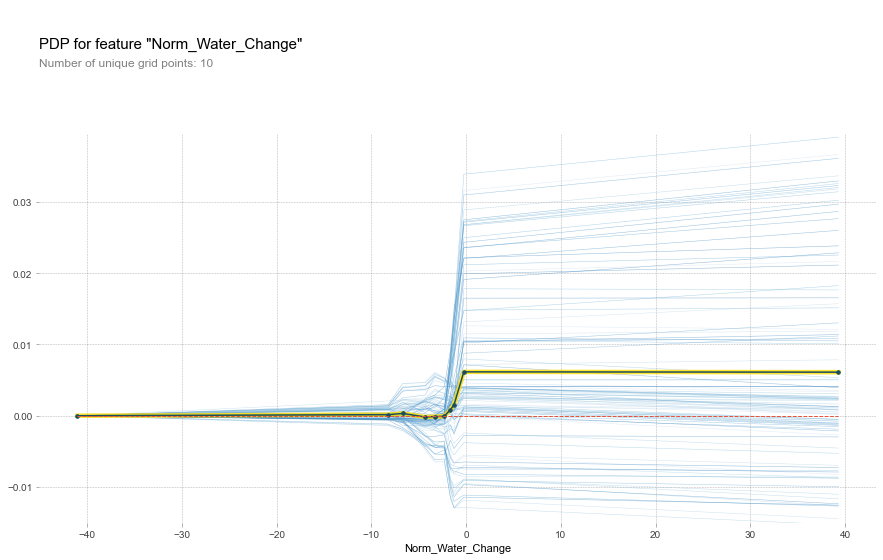

In [213]:
pdp_wct = pdp.pdp_isolate(
    model=rbt_rf, dataset=rbt_pdp, model_features=X_rbt_collinear.columns, feature='Norm_Water_Change'
)
fig, axes = pdp.pdp_plot(pdp_wct, 'Norm_Water_Change', plot_lines=True, frac_to_plot=100)


(array([ 1.,  0.,  0., 10., 97., 21.,  2.,  0.,  0.,  1.]),
 array([-41.        , -32.97160686, -24.94321373, -16.91482059,
         -8.88642746,  -0.85803432,   7.17035881,  15.19875195,
         23.22714509,  31.25553822,  39.28393136]),
 <a list of 10 Patch objects>)

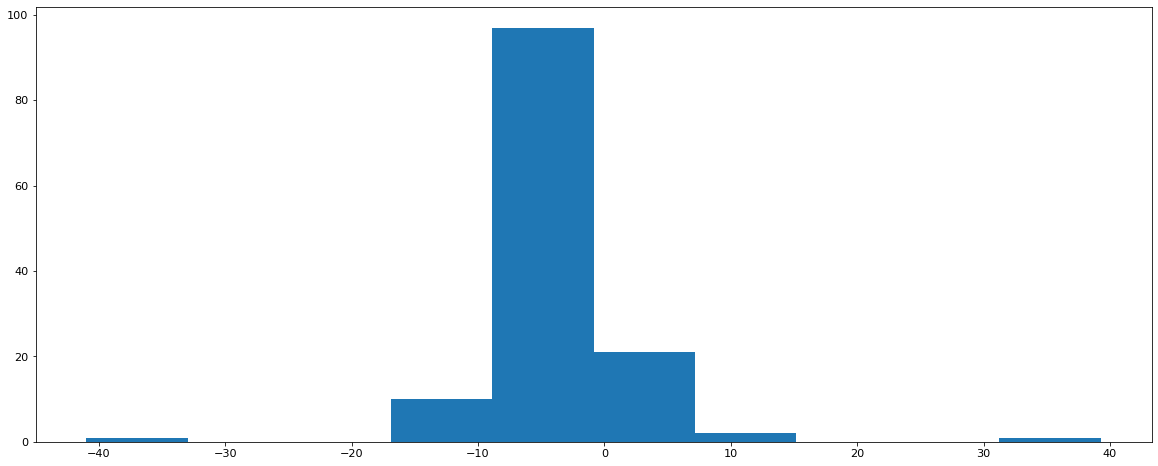

In [214]:
plt.hist(X_rbt_collinear['Norm_Water_Change'])